In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
import warnings
warnings.filterwarnings('ignore')

# Load preprocessed data
df = pd.read_csv('Data/combined_expedia_results.csv')

# Display basic information
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (44518, 15)


Snapshot Date  TTT  LOS                                         Hotel Name  \
0    2025-03-14    1    1         Courtyard New York Manhattan/ Midtown East   
1    2025-03-14    1    1           Millennium Premier New York Times Square   
2    2025-03-14    1    1                      PUBLIC, an Ian Schrager hotel   
3    2025-03-14    1    1  Residence Inn by Marriott New York Manhattan/M...   
4    2025-03-14    1    1             Hyatt Place New York City/Times Square   

   Price  Rating  Reviews  Neighborhood  Breakfast  Free Cancellation  \
0  345.0     3.0   2243.0            14          0                  0   
1  342.0     1.0   1004.0            16          1                  0   
2  635.0     2.0   2809.0            14          0                  0   
3  268.0     4.0   1001.0            14          1                  0   
4  255.0     2.0   2435.0            14          1                  0   

   Rooms Left    Check-in   Check-out  search_group  hotel_name_encoded  
0         5.0  2025-03-15  2025-03-16             0                  56  
1        -1.0  2025-03-15  2025-03-16             1                 234  
2        -1.0  2025-03-15  2025-03-16             2                 261  
3         5.0  2025-03-15  2025-03-16             3                 283  
4        -1.0  2025-03-15  2025-03-16             4                 197

## Feature Engineering
### calculating new features(based on existing ones):
- Day of the week - extracting the exact day of the week from check-in date.
- is weekend - checking if the given check-in date is in weekend.
- days to month end - checking distance between check-in day to end of current month.
- Short notice - checking if TTT is lower then 14 what means checked for hotels in less then two weeks prior.
- check in month+year for seasonality demand.
- check in day - checks specific day of month to check pricing patterns.

In [24]:
# Feature Engineering

# Extract day of week from check-in date
df['day_of_week'] = pd.to_datetime(df['Check-in']).dt.dayofweek

# Create a feature for weekend check-ins
df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

# Distance from end of month
df['days_to_month_end'] = pd.to_datetime(df['Check-in']).dt.days_in_month - pd.to_datetime(df['Check-in']).dt.day

# Short notice booking flag
df['short_notice'] = (df['TTT'] < 14).astype(int)


# Extract month and year for seasonality
df['check_in_month'] = pd.to_datetime(df['Check-in']).dt.month
df['check_in_year'] = pd.to_datetime(df['Check-in']).dt.year

# Extract day of month to capture pricing patterns
df['check_in_day'] = pd.to_datetime(df['Check-in']).dt.day

# Check the engineered features
print("\nAfter feature engineering:")
print(df.head())


After feature engineering:
  Snapshot Date  TTT  LOS                                         Hotel Name  \
0    2025-03-14    1    1         Courtyard New York Manhattan/ Midtown East   
1    2025-03-14    1    1           Millennium Premier New York Times Square   
2    2025-03-14    1    1                      PUBLIC, an Ian Schrager hotel   
3    2025-03-14    1    1  Residence Inn by Marriott New York Manhattan/M...   
4    2025-03-14    1    1             Hyatt Place New York City/Times Square   

   Price  Rating  Reviews  Neighborhood  Breakfast  Free Cancellation  ...  \
0  345.0     3.0   2243.0            14          0                  0  ...   
1  342.0     1.0   1004.0            16          1                  0  ...   
2  635.0     2.0   2809.0            14          0                  0  ...   
3  268.0     4.0   1001.0            14          1                  0  ...   
4  255.0     2.0   2435.0            14          1                  0  ...   

    Check-out search_g

In [25]:
# Data Split
# Define features and target
# Remove any non-numeric columns or convert them
X = df.drop(['Price', 'Snapshot Date', 'Check-in', 'Check-out'], axis=1)
y = df['Price']

# Check if there are any non-numeric columns left
print("\nFeature datatypes:")
print(X.dtypes)

# Convert any remaining object columns to numeric if needed
for col in X.select_dtypes(include=['object']).columns:
    X[col] = pd.to_numeric(X[col], errors='coerce')
    
# Fill any NaN values created by conversion
X = X.fillna(-1)

# Split data - 70% train, 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"\nTraining set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")


Feature datatypes:
TTT                     int64
LOS                     int64
Hotel Name             object
Rating                float64
Reviews               float64
Neighborhood            int64
Breakfast               int64
Free Cancellation       int64
Rooms Left            float64
search_group            int64
hotel_name_encoded      int64
day_of_week             int32
is_weekend              int64
days_to_month_end       int32
short_notice            int32
check_in_month          int32
check_in_year           int32
check_in_day            int32
dtype: object

Training set size: (31162, 18)
Test set size: (13356, 18)


In [26]:
# Data Normalization/Scaling
# Standard scaling (zero mean, unit variance)
scaler_standard = StandardScaler()
X_train_std = scaler_standard.fit_transform(X_train)
X_test_std = scaler_standard.transform(X_test)

# Min-Max scaling (0 to 1 range)
scaler_minmax = MinMaxScaler()
X_train_minmax = scaler_minmax.fit_transform(X_train)
X_test_minmax = scaler_minmax.transform(X_test)

# Robust scaling (uses median and quantiles, less sensitive to outliers)
scaler_robust = RobustScaler()
X_train_robust = scaler_robust.fit_transform(X_train)
X_test_robust = scaler_robust.transform(X_test)

## Data normalization, scalling and evaluation function

In [27]:
# Evaluation Metrics and Residual Plots
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name="Model", scaler_name=""):
    # Train and predict
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate metrics
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    train_rmse = np.sqrt(train_mse)
    test_rmse = np.sqrt(test_mse)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    # Print results
    scaling_info = f" with {scaler_name}" if scaler_name else ""
    print(f"\n{model_name}{scaling_info} Performance:")
    print(f"Train MSE: {train_mse:.2f}, Test MSE: {test_mse:.2f}")
    print(f"Train RMSE: {train_rmse:.2f}, Test RMSE: {test_rmse:.2f}")
    print(f"Train MAE: {train_mae:.2f}, Test MAE: {test_mae:.2f}")
    print(f"Train R²: {train_r2:.4f}, Test R²: {test_r2:.4f}")
    
    # Plot residuals
    plt.figure(figsize=(12, 5))
    
    # Training residuals
    plt.subplot(1, 2, 1)
    residuals_train = y_train - y_train_pred
    plt.scatter(y_train_pred, residuals_train, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='-')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title(f'{model_name} - Training Residuals')
    
    # Test residuals
    plt.subplot(1, 2, 2)
    residuals_test = y_test - y_test_pred
    plt.scatter(y_test_pred, residuals_test, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='-')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title(f'{model_name} - Test Residuals')
    
    plt.tight_layout()
    plt.show()
    
    # Plot a residual histogram
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.hist(residuals_train, bins=30, alpha=0.7)
    plt.axvline(x=0, color='r', linestyle='-')
    plt.xlabel('Residual Value')
    plt.ylabel('Frequency')
    plt.title(f'{model_name} - Training Residuals Distribution')
    
    plt.subplot(1, 2, 2)
    plt.hist(residuals_test, bins=30, alpha=0.7)
    plt.axvline(x=0, color='r', linestyle='-')
    plt.xlabel('Residual Value')
    plt.ylabel('Frequency')
    plt.title(f'{model_name} - Test Residuals Distribution')
    
    plt.tight_layout()
    plt.show()
    
    return {
        'model': model,
        'train_mse': train_mse,
        'test_mse': test_mse,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_mae': train_mae,
        'test_mae': test_mae,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'y_test_pred': y_test_pred
    }

# Regression models


--- Linear Regression ---

Linear Regression with StandardScaler Performance:
Train MSE: 56213.79, Test MSE: 58222.33
Train RMSE: 237.09, Test RMSE: 241.29
Train MAE: 169.69, Test MAE: 171.24
Train R²: 0.7987, Test R²: 0.7915


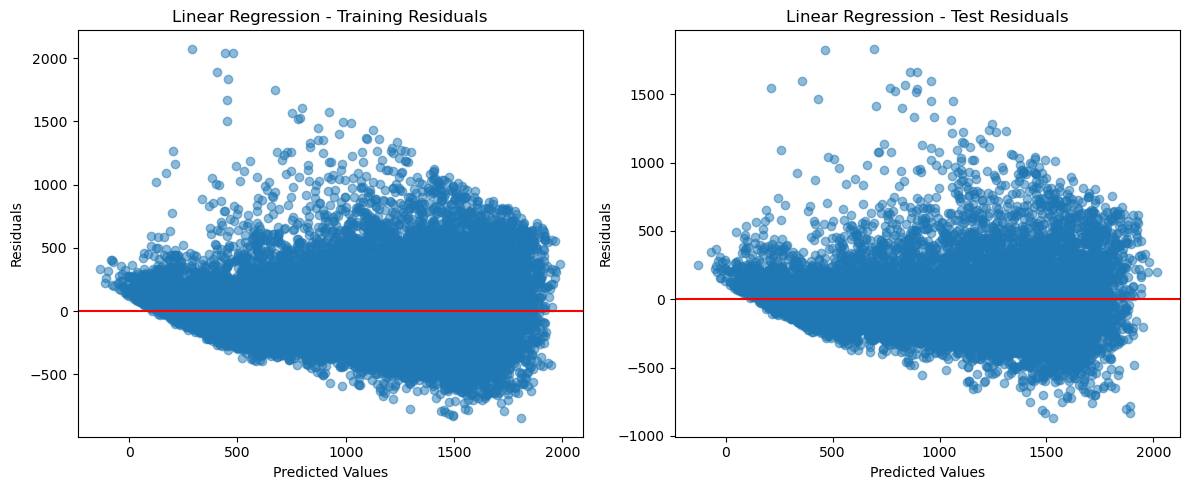

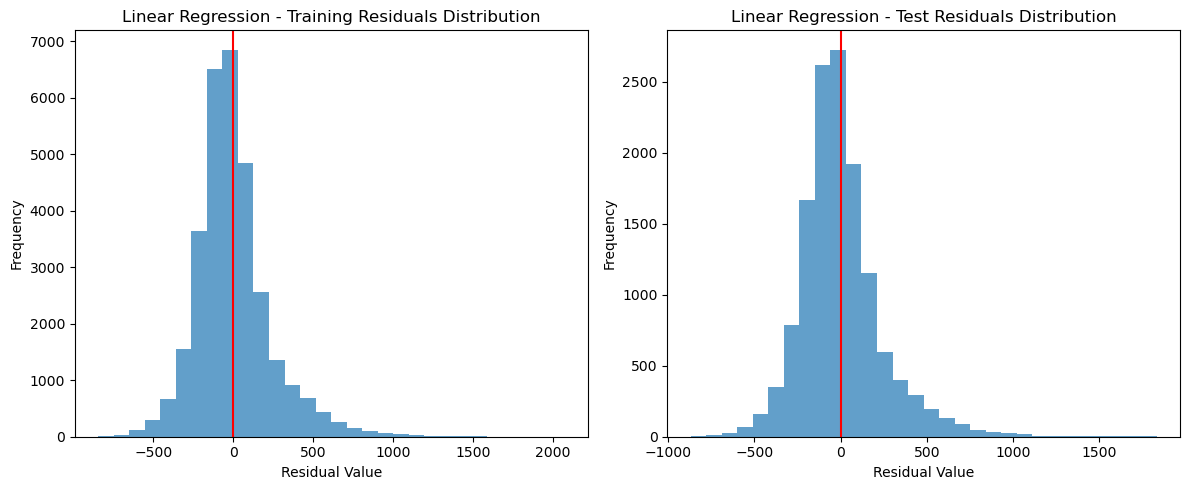


Linear Regression with MinMaxScaler Performance:
Train MSE: 56213.79, Test MSE: 58222.33
Train RMSE: 237.09, Test RMSE: 241.29
Train MAE: 169.69, Test MAE: 171.24
Train R²: 0.7987, Test R²: 0.7915


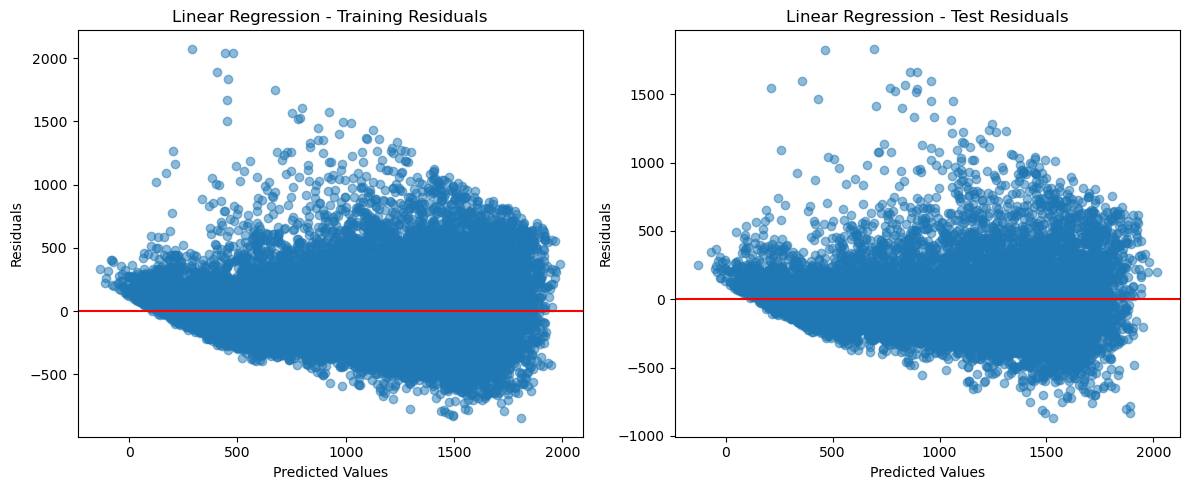

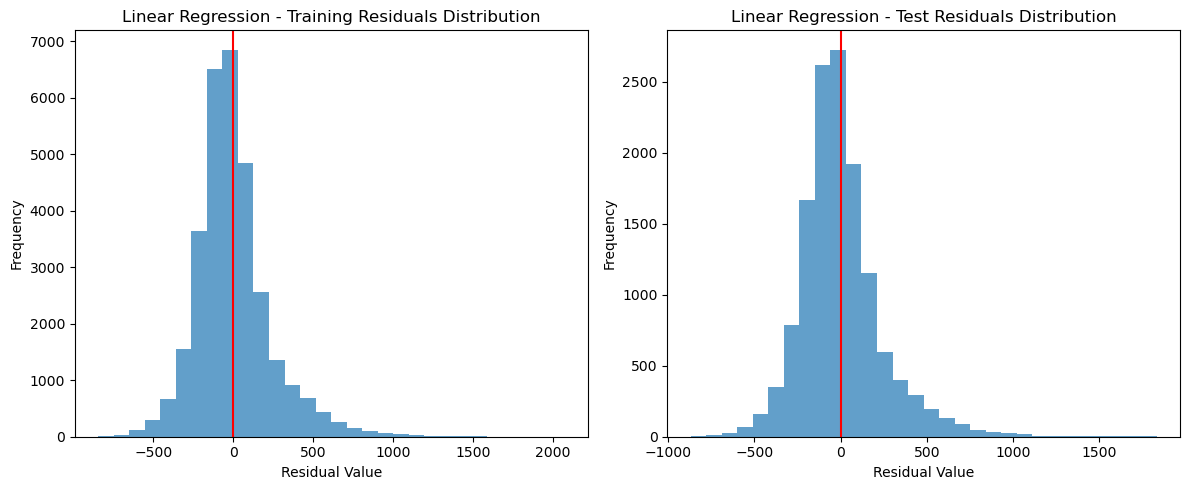


--- Decision Tree Regressor ---

Decision Tree Regressor Performance:
Train MSE: 45455.12, Test MSE: 48409.84
Train RMSE: 213.20, Test RMSE: 220.02
Train MAE: 146.73, Test MAE: 150.44
Train R²: 0.8372, Test R²: 0.8267


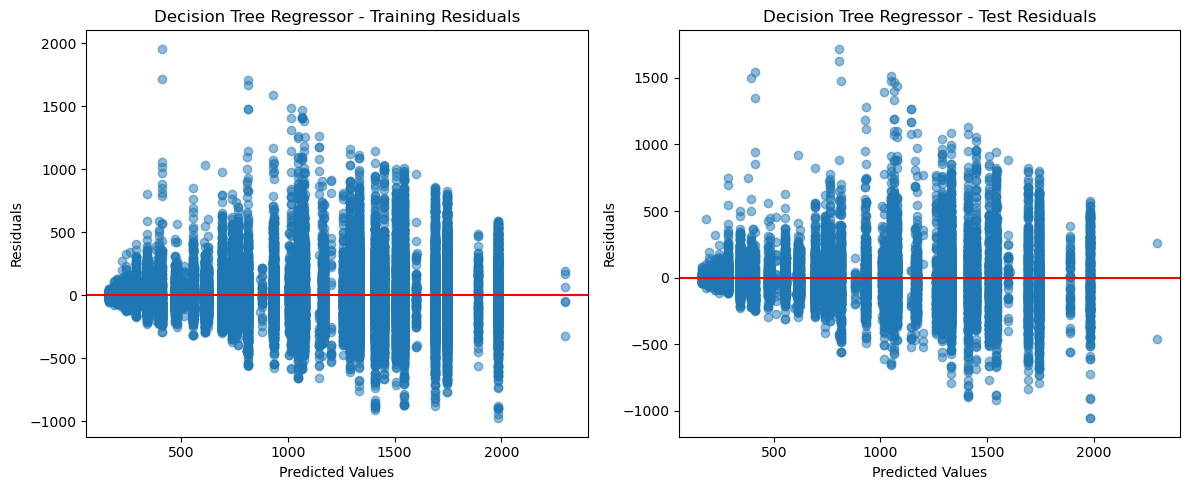

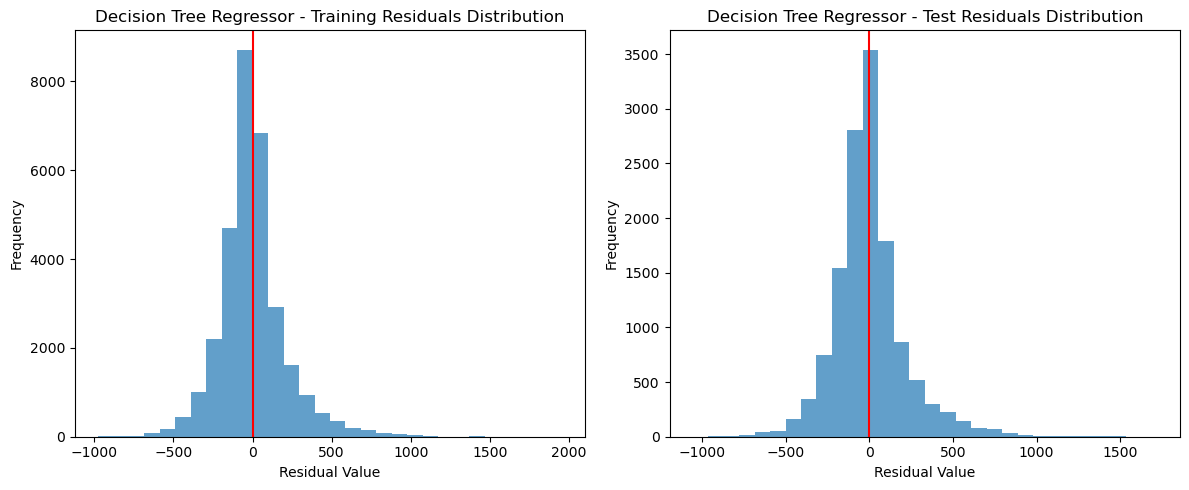

Best parameters: {'criterion': 'squared_error', 'max_depth': 6, 'min_samples_split': 2}

--- Gaussian Process Regressor ---

Testing GPR with RBF kernel

Gaussian Process Regressor (RBF) Performance:
Train MSE: 0.00, Test MSE: 57119.31
Train RMSE: 0.00, Test RMSE: 239.00
Train MAE: 0.00, Test MAE: 174.40
Train R²: 1.0000, Test R²: 0.8044


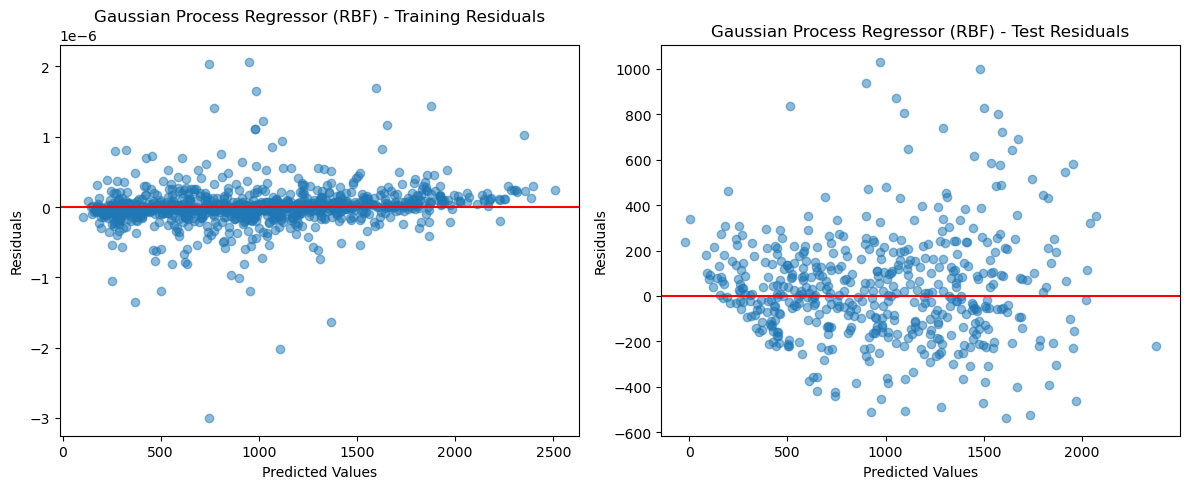

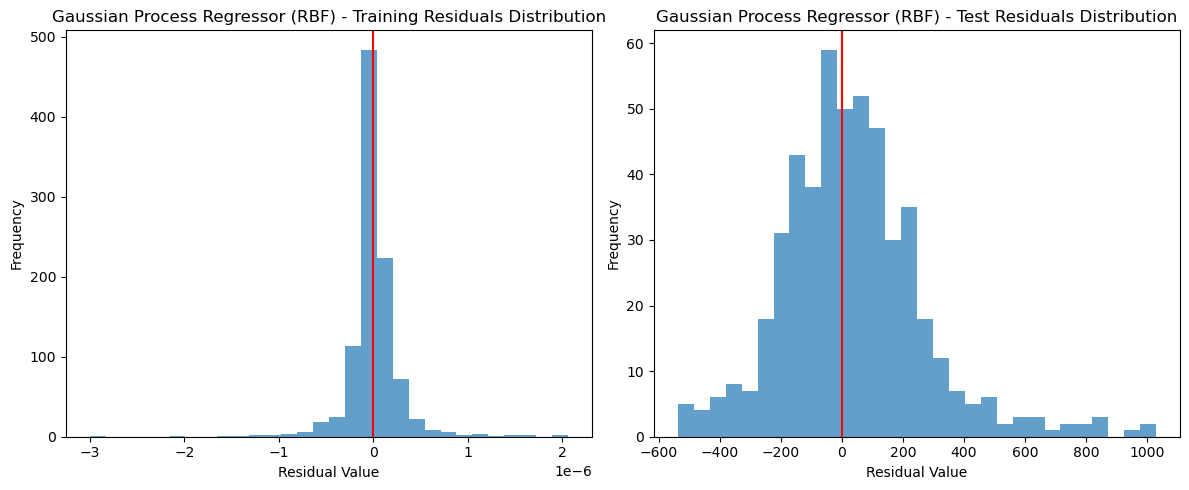


Testing GPR with RBF+White kernel

Gaussian Process Regressor (RBF+White) Performance:
Train MSE: 21205.52, Test MSE: 39467.42
Train RMSE: 145.62, Test RMSE: 198.66
Train MAE: 103.93, Test MAE: 140.02
Train R²: 0.9226, Test R²: 0.8649


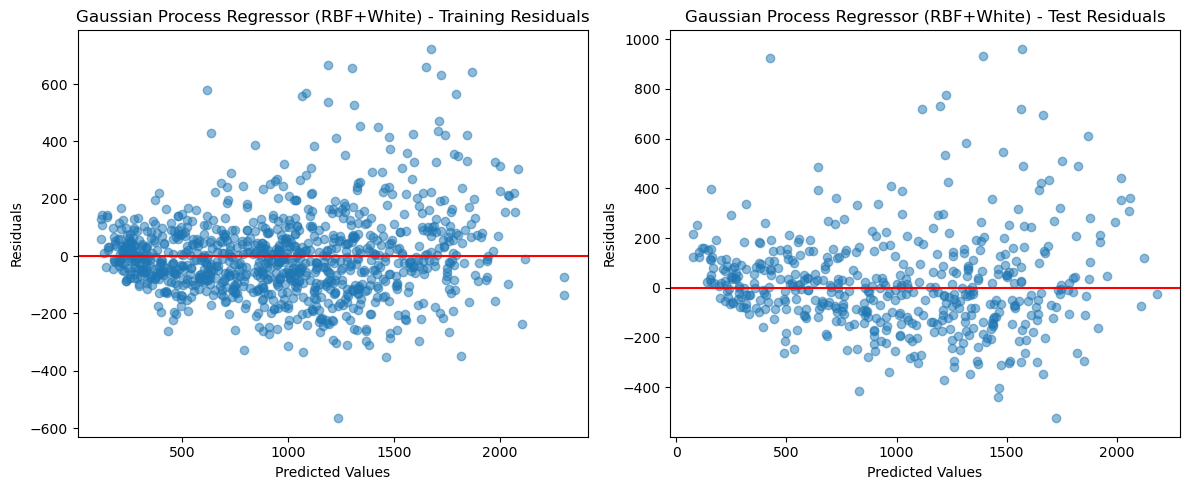

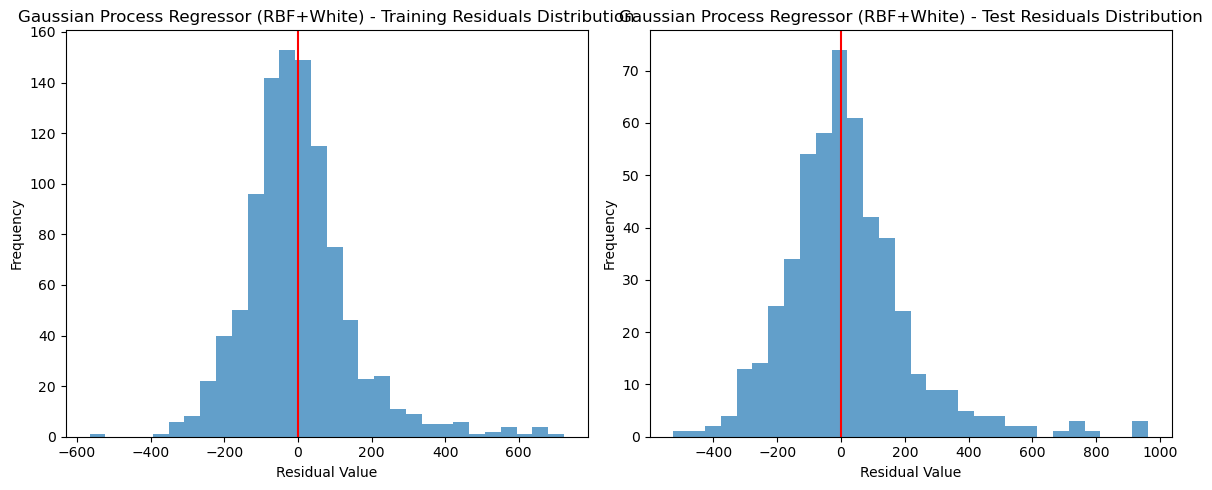


Testing GPR with RQ+White kernel

Gaussian Process Regressor (RQ+White) Performance:
Train MSE: 22672.89, Test MSE: 40044.16
Train RMSE: 150.58, Test RMSE: 200.11
Train MAE: 107.17, Test MAE: 141.07
Train R²: 0.9172, Test R²: 0.8629


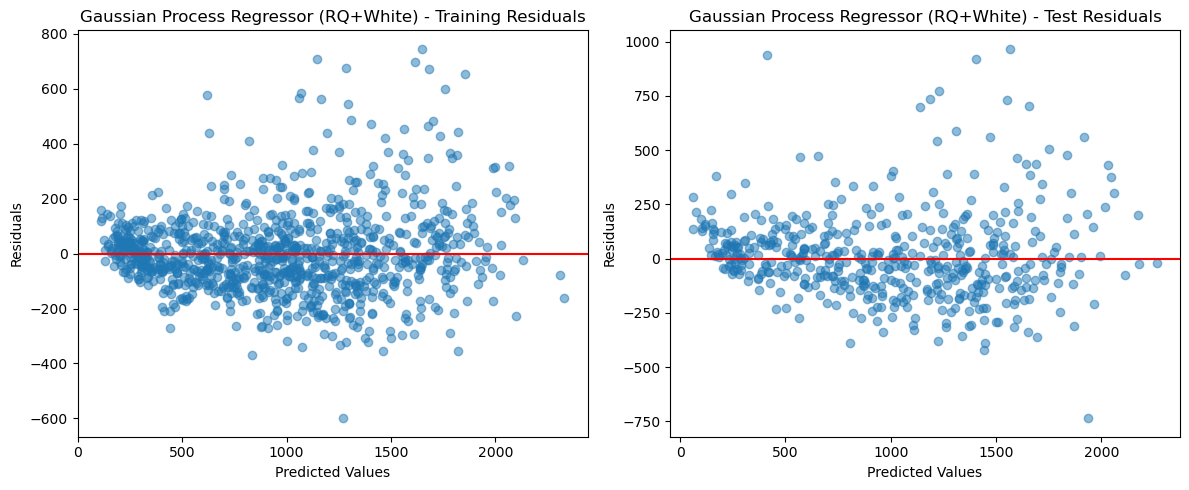

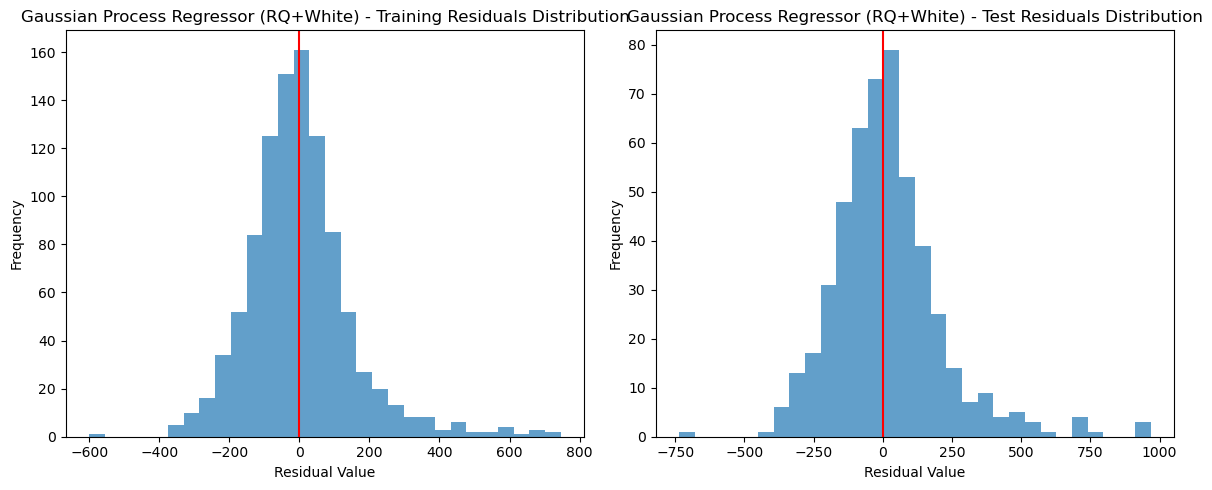


Best GPR kernel: RBF+White with R² score: 0.8649

--- Random Forest Regressor ---

Random Forest (GridSearch) Performance:
Train MSE: 64948.37, Test MSE: 65760.20
Train RMSE: 254.85, Test RMSE: 256.44
Train MAE: 181.15, Test MAE: 181.37
Train R²: 0.7674, Test R²: 0.7645


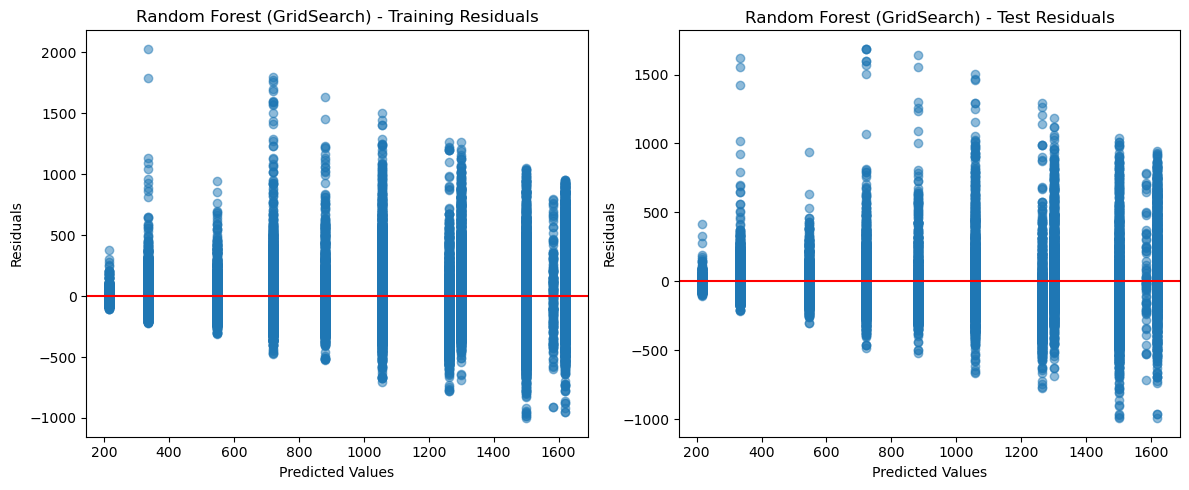

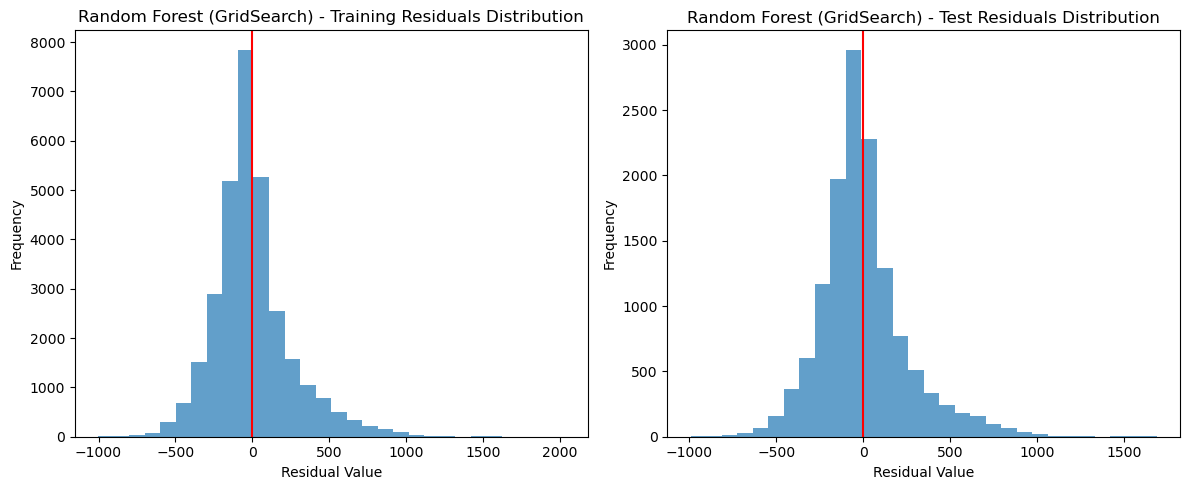

Best RF parameters: {'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 100}

--- Gradient Boosting Regressor ---

Gradient Boosting Regressor Performance:
Train MSE: 24736.98, Test MSE: 27001.34
Train RMSE: 157.28, Test RMSE: 164.32
Train MAE: 104.78, Test MAE: 108.56
Train R²: 0.9114, Test R²: 0.9033


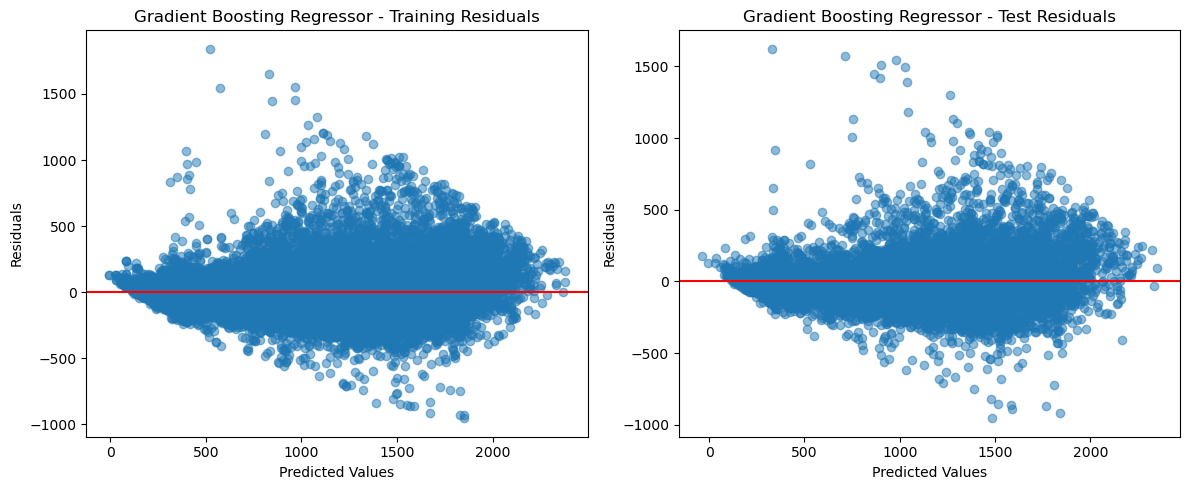

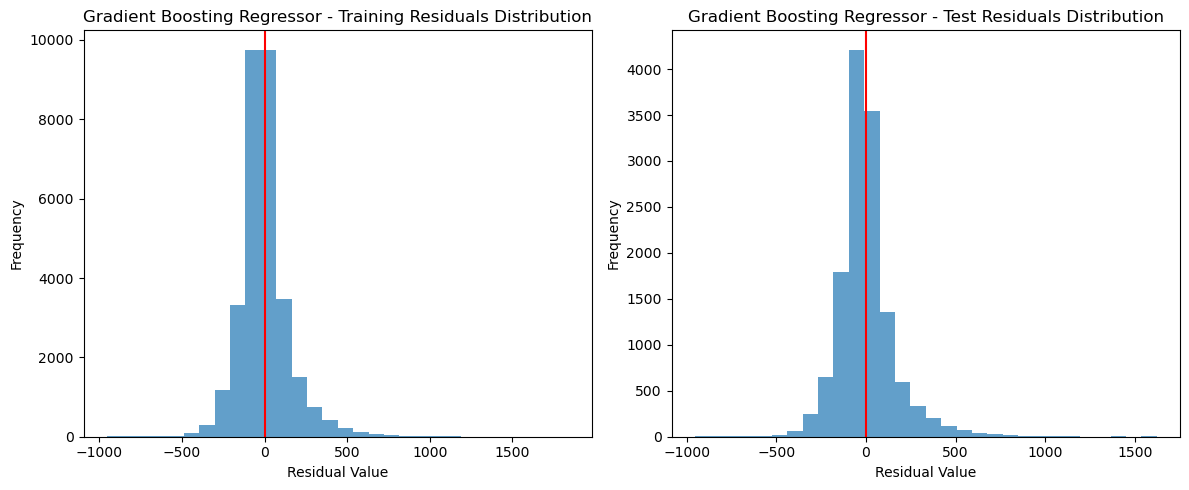


--- Support Vector Regression ---

SVR with linear kernel:

SVR (linear) Performance:
Train MSE: 60482.61, Test MSE: 56019.78
Train RMSE: 245.93, Test RMSE: 236.68
Train MAE: 165.54, Test MAE: 163.50
Train R²: 0.7850, Test R²: 0.7960


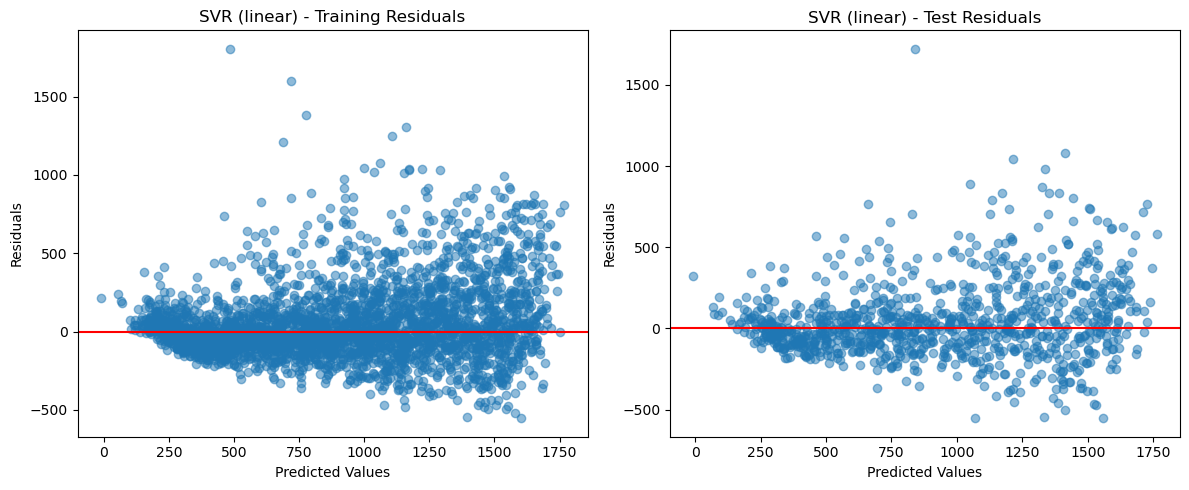

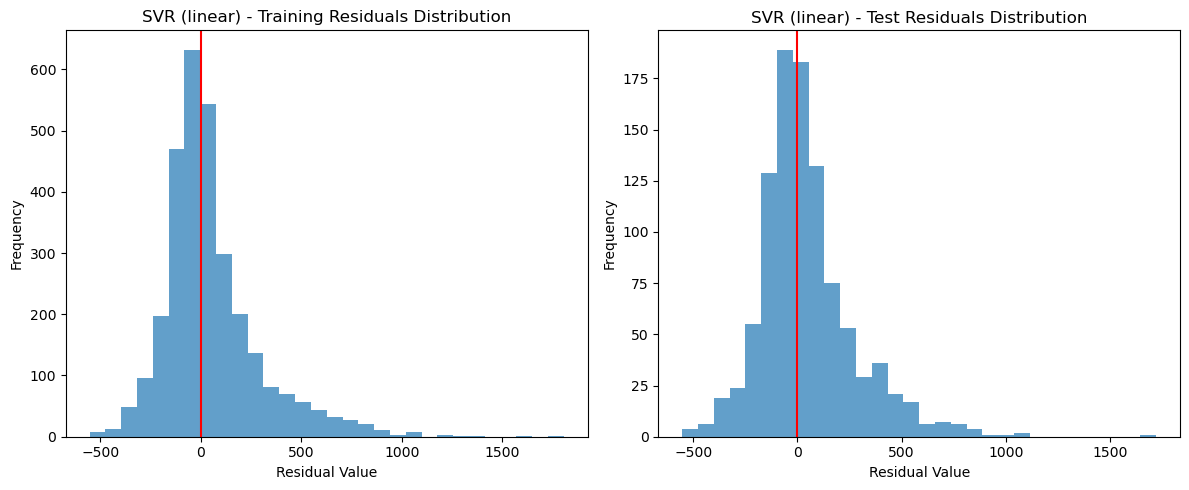


SVR with poly kernel:

SVR (poly) Performance:
Train MSE: 229550.54, Test MSE: 225551.64
Train RMSE: 479.11, Test RMSE: 474.92
Train MAE: 390.60, Test MAE: 389.10
Train R²: 0.1838, Test R²: 0.1787


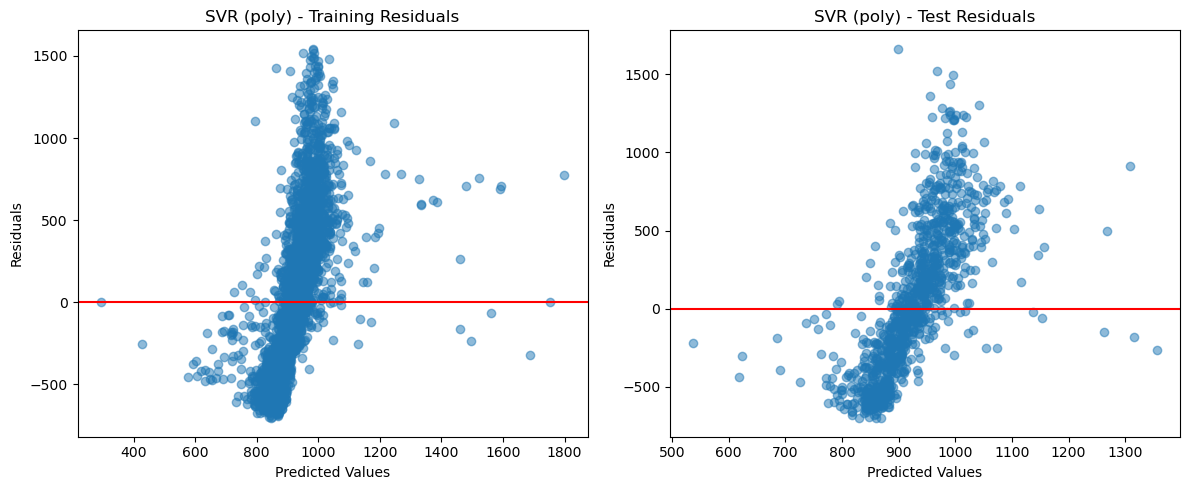

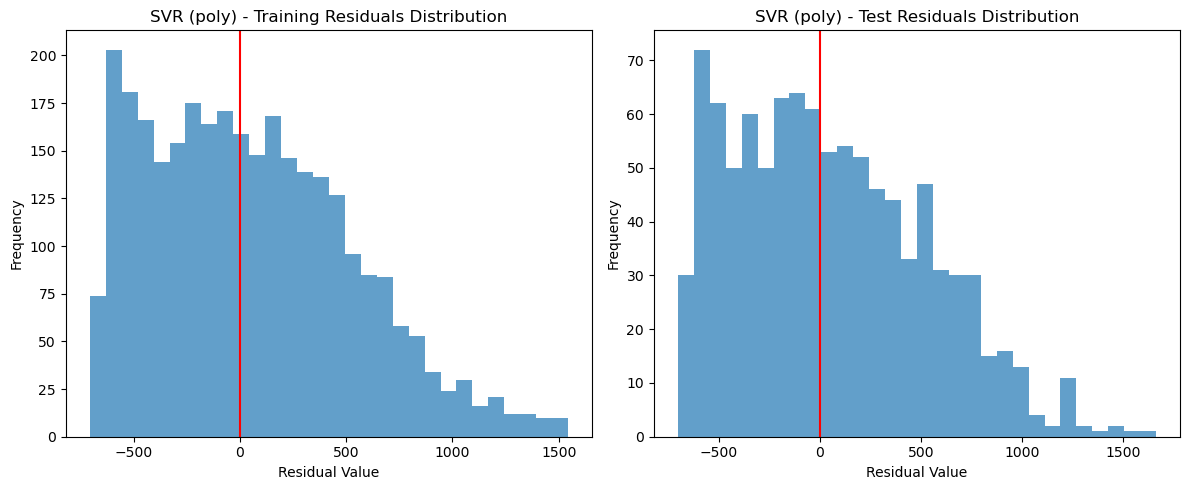


SVR with rbf kernel:

SVR (rbf) Performance:
Train MSE: 232884.09, Test MSE: 226522.63
Train RMSE: 482.58, Test RMSE: 475.94
Train MAE: 393.10, Test MAE: 389.64
Train R²: 0.1720, Test R²: 0.1752


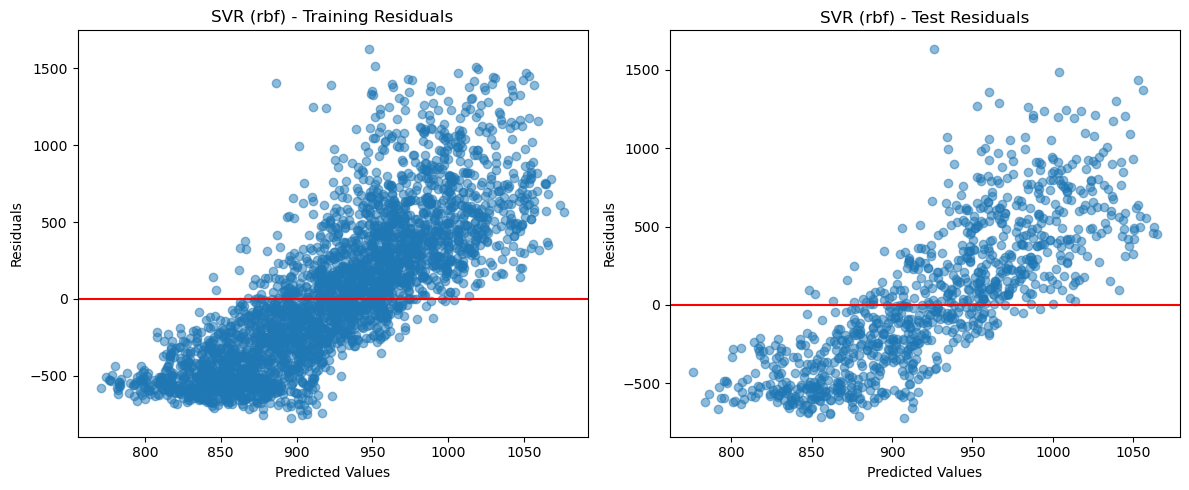

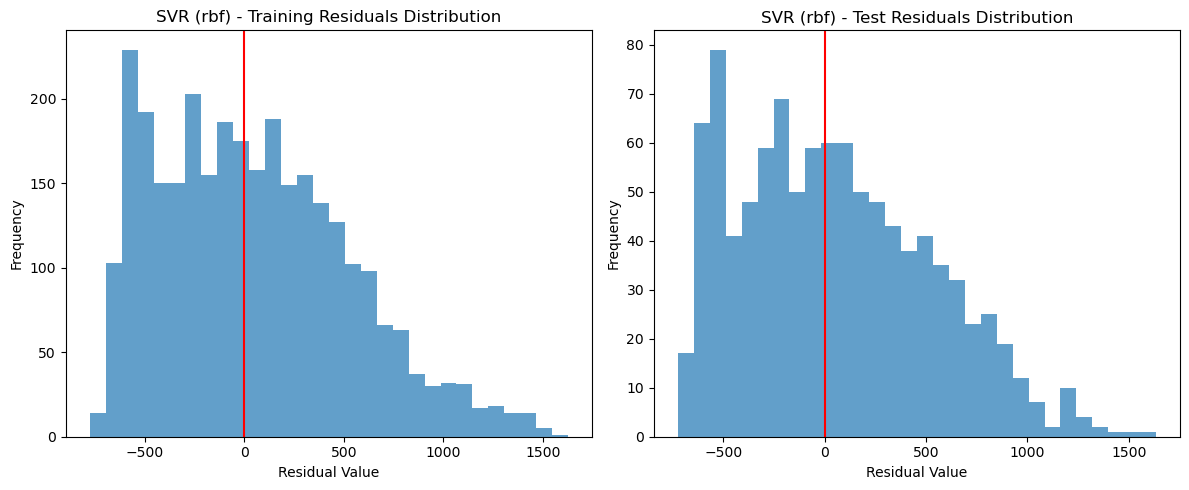


models comparison:
  1. Linear Regression (Standard)
  2. Linear Regression (MinMax)
  3. Decision Tree
  4. Gaussian Process (RBF+White)
  5. Random Forest
  6. Gradient Boosting
  7. SVR

=== Models Performance Comparison ===
                       Model       R²        MAE           MSE       RMSE
           Gradient Boosting 0.903315 108.555058  27001.342418 164.320852
Gaussian Process (RBF+White) 0.864864        NaN           NaN        NaN
               Decision Tree 0.826656 150.438665  48409.838585 220.022359
Linear Regression (Standard) 0.791520 171.241098  58222.333292 241.293044
  Linear Regression (MinMax) 0.791520 171.241098  58222.333292 241.293044
               Random Forest 0.764528 181.368643  65760.199347 256.437515
                         SVR 0.175206 389.640073 226522.629721 475.943935


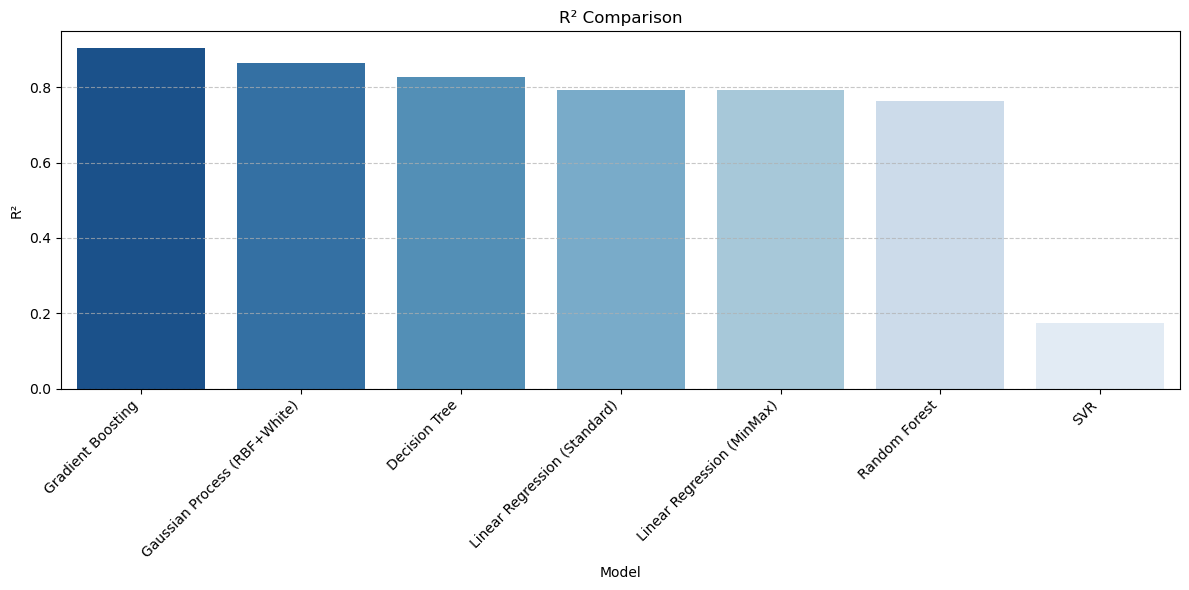

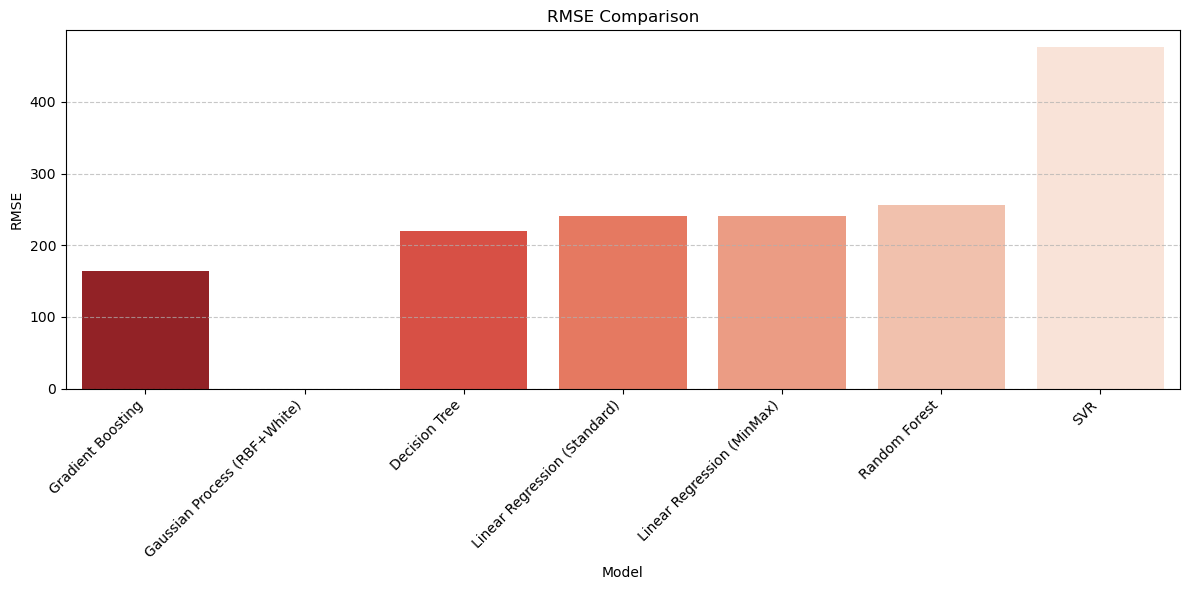

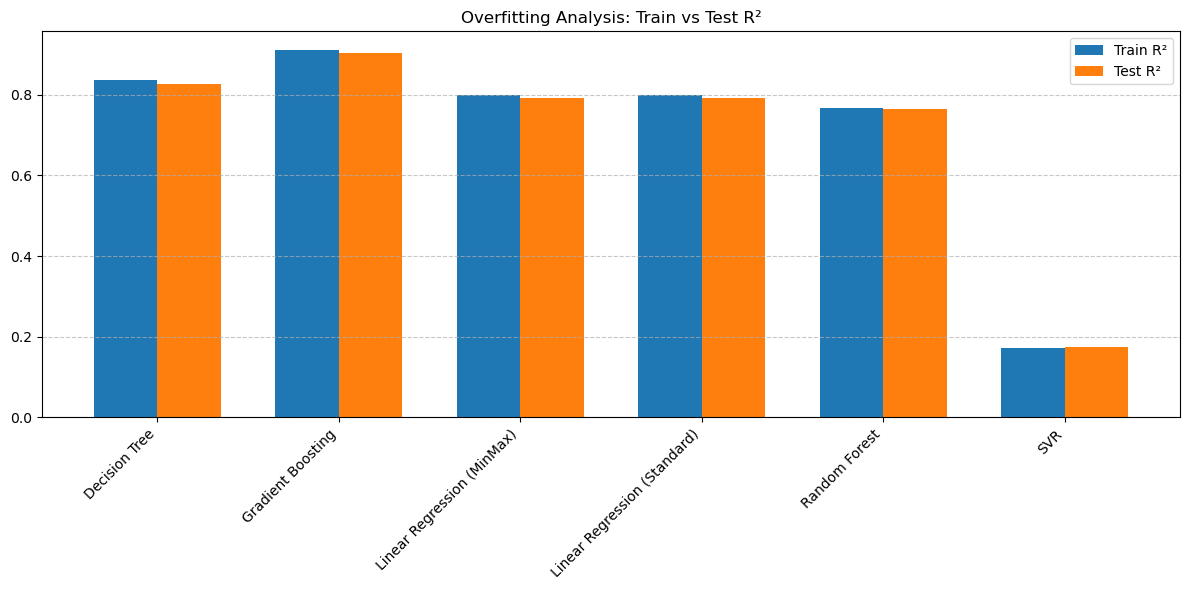

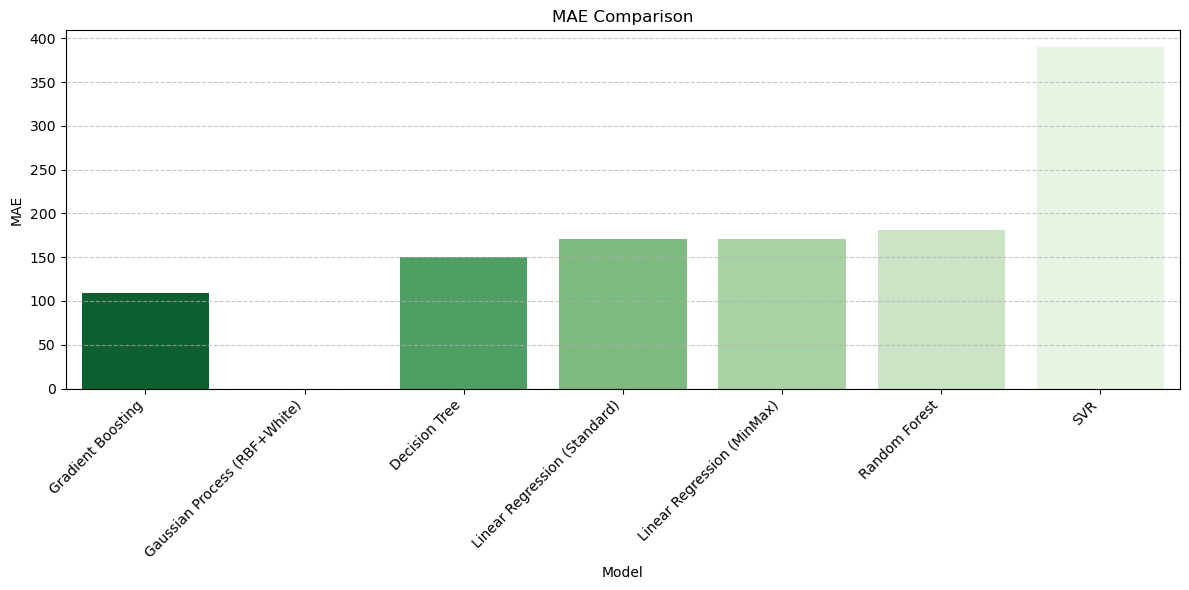


=== Best Performing Model ===
Model: Gradient Boosting
R² Score: 0.9033
RMSE: 164.32
MAE: 108.56


Model        R²         MAE            MSE  \
5             Gradient Boosting  0.903315  108.555058   27001.342418   
3  Gaussian Process (RBF+White)  0.864864         NaN            NaN   
2                 Decision Tree  0.826656  150.438665   48409.838585   
0  Linear Regression (Standard)  0.791520  171.241098   58222.333292   
1    Linear Regression (MinMax)  0.791520  171.241098   58222.333292   
4                 Random Forest  0.764528  181.368643   65760.199347   
6                           SVR  0.175206  389.640073  226522.629721   

         RMSE  Train R²  Overfitting  
5  164.320852  0.911400     0.008085  
3         NaN       NaN          NaN  
2  220.022359  0.837194     0.010538  
0  241.293044  0.798659     0.007140  
1  241.293044  0.798659     0.007140  
4  256.437515  0.767375     0.002847  
6  475.943935  0.171966    -0.003240

In [28]:
# Linear Regression
print("\n--- Linear Regression ---")
lr_model = LinearRegression()
lr_results_std = evaluate_model(lr_model, X_train_std, X_test_std, y_train, y_test, 
                               "Linear Regression", "StandardScaler")

# Try with different scaling methods to compare
lr_model_minmax = LinearRegression()
lr_results_minmax = evaluate_model(lr_model_minmax, X_train_minmax, X_test_minmax, y_train, y_test, 
                                  "Linear Regression", "MinMaxScaler")

# Decision Tree Regressor with different parameters
print("\n--- Decision Tree Regressor ---")
dt_params = {
    'max_depth': [3 ,6], 
    'min_samples_split': [2,5],
    'criterion': ['squared_error']
}
dt_grid = GridSearchCV(DecisionTreeRegressor(random_state=42), dt_params, cv=3, scoring='neg_mean_squared_error')
dt_results = evaluate_model(dt_grid, X_train, X_test, y_train, y_test, "Decision Tree Regressor")
print(f"Best parameters: {dt_grid.best_params_}")

# Gaussian Process Regressor
print("\n--- Gaussian Process Regressor ---")

# Use stratified sampling for better representation (if possible)
sample_size = min(1000, len(X_train))
test_sample_size = min(500, len(X_test))

# Create a smaller sample for GPR
np.random.seed(42)
train_indices = np.random.choice(len(X_train_std), sample_size, replace=False)
test_indices = np.random.choice(len(X_test_std), test_sample_size, replace=False)

X_train_sample = X_train_std[train_indices]
y_train_sample = y_train.iloc[train_indices]
X_test_sample = X_test_std[test_indices]
y_test_sample = y_test.iloc[test_indices]

#kernel configurations
kernels = [
    ("RBF", RBF(length_scale=1.0)),
    ("RBF+White", RBF(length_scale=1.0) + WhiteKernel(noise_level=0.1)),  # Reduced noise
    ("RQ+White", RBF(length_scale=1.0) * ConstantKernel(1.0) + WhiteKernel(noise_level=0.1))
]

best_gpr_score = float('-inf')
best_gpr_model = None
best_gpr_kernel_name = ""

for kernel_name, kernel in kernels:
    print(f"\nTesting GPR with {kernel_name} kernel")
    # Add normalize_y=True to handle scale issues
    gpr_model = GaussianProcessRegressor(
        kernel=kernel, 
        n_restarts_optimizer=5, 
        normalize_y=True,  
        random_state=42
    )
    
    try:
        gpr_results = evaluate_model(gpr_model, X_train_sample, X_test_sample, 
                                    y_train_sample, y_test_sample, 
                                    f"Gaussian Process Regressor ({kernel_name})")
        
        # Track the best GPR model
        if gpr_results['test_r2'] > best_gpr_score:
            best_gpr_score = gpr_results['test_r2']
            best_gpr_model = gpr_model
            best_gpr_kernel_name = kernel_name
            
    except Exception as e:
        print(f"Error with {kernel_name} kernel: {e}")

print(f"\nBest GPR kernel: {best_gpr_kernel_name} with R² score: {best_gpr_score:.4f}")

# Random Forest Regressor
print("\n--- Random Forest Regressor ---")

# Quick grid search for Random Forest
rf_params = {
    'n_estimators': [50, 100],
    'max_depth': [2, 3],
    'min_samples_split': [2, 5]
}
rf_grid = GridSearchCV(RandomForestRegressor(random_state=42), rf_params, cv=3, 
                      scoring='neg_mean_squared_error', n_jobs=-1)
rf_grid_results = evaluate_model(rf_grid, X_train, X_test, y_train, y_test, "Random Forest (GridSearch)")
print(f"Best RF parameters: {rf_grid.best_params_}")

# Gradient Boosting Regressor
print("\n--- Gradient Boosting Regressor ---")

gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_results = evaluate_model(gb_model, X_train, X_test, y_train, y_test, "Gradient Boosting Regressor")

# Support Vector Regression
print("\n--- Support Vector Regression ---")

# Sample the data for SVR - it can be slow on large datasets
sample_size_svr = min(3000, len(X_train))
test_sample_size_svr = min(1000, len(X_test))

# Create a smaller sample for SVR
X_train_sample_svr = X_train_std[:sample_size_svr]
y_train_sample_svr = y_train.iloc[:sample_size_svr]
X_test_sample_svr = X_test_std[:test_sample_size_svr]
y_test_sample_svr = y_test.iloc[:test_sample_size_svr]

# Try different kernels for SVR
kernels = ['linear', 'poly', 'rbf']
for kernel in kernels:
    print(f"\nSVR with {kernel} kernel:")
    svr_model = SVR(kernel=kernel, C=1.0, epsilon=0.1)
    try:
        svr_kernel_results = evaluate_model(
            svr_model, 
            X_train_sample_svr, 
            X_test_sample_svr, 
            y_train_sample_svr, 
            y_test_sample_svr,
            f"SVR ({kernel})"
        )
    except Exception as e:
        print(f"Error with SVR {kernel} kernel: {e}")


def compare_models(): 
    # Get all variables from global scope
    globals_dict = globals()
    
    # Initialize results list
    results = []
    
    # Track models found for reporting
    models_found = []
    
    # 1. LINEAR REGRESSION
    try:
        if 'lr_results_std' in globals_dict:
            results.append({
                'Model': 'Linear Regression (Standard)',
                'R²': globals_dict['lr_results_std']['test_r2'],
                'MAE': globals_dict['lr_results_std']['test_mae'],
                'MSE': globals_dict['lr_results_std']['test_mse'],
                'RMSE': globals_dict['lr_results_std']['test_rmse'],
                'Train R²': globals_dict['lr_results_std']['train_r2']
            })
            models_found.append("Linear Regression (Standard)")
        
        if 'lr_results_minmax' in globals_dict:
            results.append({
                'Model': 'Linear Regression (MinMax)',
                'R²': globals_dict['lr_results_minmax']['test_r2'],
                'MAE': globals_dict['lr_results_minmax']['test_mae'],
                'MSE': globals_dict['lr_results_minmax']['test_mse'],
                'RMSE': globals_dict['lr_results_minmax']['test_rmse'],
                'Train R²': globals_dict['lr_results_minmax']['train_r2']
            })
            models_found.append("Linear Regression (MinMax)")
    except Exception as e:
        print(f"Error adding Linear Regression models: {e}")
    
    # 2. DECISION TREE
    try:
        if 'dt_results' in globals_dict:
            results.append({
                'Model': 'Decision Tree',
                'R²': globals_dict['dt_results']['test_r2'],
                'MAE': globals_dict['dt_results']['test_mae'],
                'MSE': globals_dict['dt_results']['test_mse'],
                'RMSE': globals_dict['dt_results']['test_rmse'],
                'Train R²': globals_dict['dt_results']['train_r2']
            })
            models_found.append("Decision Tree")
    except Exception as e:
        print(f"Error adding Decision Tree: {e}")
    
    # 3. GAUSSIAN PROCESS REGRESSOR
    try:
        if 'best_gpr_score' in globals_dict and 'best_gpr_kernel_name' in globals_dict:
            # Find full GPR results if available
            gpr_results = None
            for var_name, var_val in globals_dict.items():
                if var_name.startswith('gpr_results') and isinstance(var_val, dict):
                    if var_val['test_r2'] == globals_dict['best_gpr_score']:
                        gpr_results = var_val
                        break
            
            if gpr_results:
                results.append({
                    'Model': f"Gaussian Process ({globals_dict['best_gpr_kernel_name']})",
                    'R²': gpr_results['test_r2'],
                    'MAE': gpr_results['test_mae'],
                    'MSE': gpr_results['test_mse'],
                    'RMSE': gpr_results['test_rmse'],
                    'Train R²': gpr_results['train_r2']
                })
            else:
                # If full results not found, add with just R² score
                results.append({
                    'Model': f"Gaussian Process ({globals_dict['best_gpr_kernel_name']})",
                    'R²': globals_dict['best_gpr_score'],
                    'MAE': np.nan,
                    'MSE': np.nan,
                    'RMSE': np.nan,
                    'Train R²': np.nan
                })
            models_found.append(f"Gaussian Process ({globals_dict['best_gpr_kernel_name']})")
    except Exception as e:
        print(f"Error adding Gaussian Process Regressor: {e}")
    
    # 4. RANDOM FOREST
    try:
        if 'rf_grid_results' in globals_dict:
            results.append({
                'Model': 'Random Forest',
                'R²': globals_dict['rf_grid_results']['test_r2'],
                'MAE': globals_dict['rf_grid_results']['test_mae'],
                'MSE': globals_dict['rf_grid_results']['test_mse'],
                'RMSE': globals_dict['rf_grid_results']['test_rmse'],
                'Train R²': globals_dict['rf_grid_results']['train_r2']
            })
            models_found.append("Random Forest")
    except Exception as e:
        print(f"Error adding Random Forest: {e}")
    
    # 5. GRADIENT BOOSTING
    try:
        if 'gb_results' in globals_dict:
            results.append({
                'Model': 'Gradient Boosting',
                'R²': globals_dict['gb_results']['test_r2'],
                'MAE': globals_dict['gb_results']['test_mae'],
                'MSE': globals_dict['gb_results']['test_mse'],
                'RMSE': globals_dict['gb_results']['test_rmse'],
                'Train R²': globals_dict['gb_results']['train_r2']
            })
            models_found.append("Gradient Boosting")
    except Exception as e:
        print(f"Error adding Gradient Boosting: {e}")
    
    # 6. SUPPORT VECTOR REGRESSION
    try:
        # Check for different kernel results
        for kernel in ['linear', 'poly', 'rbf']:
            var_name = f'svr_kernel_results_{kernel}'
            if var_name in globals_dict:
                results.append({
                    'Model': f'SVR ({kernel})',
                    'R²': globals_dict[var_name]['test_r2'],
                    'MAE': globals_dict[var_name]['test_mae'],
                    'MSE': globals_dict[var_name]['test_mse'],
                    'RMSE': globals_dict[var_name]['test_rmse'],
                    'Train R²': globals_dict[var_name]['train_r2']
                })
                models_found.append(f"SVR ({kernel})")
        
        # Check for generic SVR results
        if 'svr_kernel_results' in globals_dict:
            results.append({
                'Model': 'SVR',
                'R²': globals_dict['svr_kernel_results']['test_r2'],
                'MAE': globals_dict['svr_kernel_results']['test_mae'],
                'MSE': globals_dict['svr_kernel_results']['test_mse'],
                'RMSE': globals_dict['svr_kernel_results']['test_rmse'],
                'Train R²': globals_dict['svr_kernel_results']['train_r2']
            })
            models_found.append("SVR")
    except Exception as e:
        print(f"Error adding SVR models: {e}")
    
    # Print summary of models found
    print(f"\nmodels comparison:")
    for i, model in enumerate(models_found, 1):
        print(f"  {i}. {model}")
    
    # Convert to DataFrame
    if results:
        results_df = pd.DataFrame(results)
        
        # Sort by R² (descending)
        results_df = results_df.sort_values(by='R²', ascending=False)
        
        # Display as table
        print("\n=== Models Performance Comparison ===")
        print(results_df[['Model', 'R²', 'MAE', 'MSE', 'RMSE']].to_string(index=False))
        
        # ========== Create Visualizations ==========
        
        # 1. R² Comparison
        plt.figure(figsize=(12, 6))
        plt.title('R² Comparison')
        ax = sns.barplot(data=results_df, x='Model', y='R²', palette='Blues_r')
        plt.xticks(rotation=45, ha='right')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()
        
        # 2. RMSE Comparison
        plt.figure(figsize=(12, 6))
        plt.title('RMSE Comparison')
        ax = sns.barplot(data=results_df, x='Model', y='RMSE', palette='Reds_r')
        plt.xticks(rotation=45, ha='right')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()
        
        # 3. Overfitting Analysis
        results_df['Overfitting'] = results_df['Train R²'] - results_df['R²']
        results_df_sorted = results_df.sort_values(by='Model')
        
        # Only include models that have both train and test R²
        mask = ~(results_df_sorted['Train R²'].isna() | results_df_sorted['R²'].isna())
        results_df_filtered = results_df_sorted[mask]
        
        if not results_df_filtered.empty:
            plt.figure(figsize=(12, 6))
            plt.title('Overfitting Analysis: Train vs Test R²')
            x = np.arange(len(results_df_filtered))
            width = 0.35
            plt.bar(x - width/2, results_df_filtered['Train R²'], width, label='Train R²')
            plt.bar(x + width/2, results_df_filtered['R²'], width, label='Test R²')
            plt.xticks(x, results_df_filtered['Model'], rotation=45, ha='right')
            plt.legend()
            plt.grid(axis='y', linestyle='--', alpha=0.7)
            plt.tight_layout()
            plt.show()
        
        # 4. MAE Comparison
        plt.figure(figsize=(12, 6))
        plt.title('MAE Comparison')
        ax = sns.barplot(data=results_df, x='Model', y='MAE', palette='Greens_r')
        plt.xticks(rotation=45, ha='right')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()
        
        # ========== Identify Best Model ==========
        best_model = results_df.iloc[0]['Model']
        best_r2 = results_df.iloc[0]['R²']
        print(f"\n=== Best Performing Model ===")
        print(f"Model: {best_model}")
        print(f"R² Score: {best_r2:.4f}")
        print(f"RMSE: {results_df.iloc[0]['RMSE']:.2f}")
        print(f"MAE: {results_df.iloc[0]['MAE']:.2f}")
        
        
        return results_df
    else:
        print("No model results found. Please check that models have been trained and evaluated.")
        return None

compare_models()

# Conclusions
### Linear Regression
The Linear Regression model achieves a respectable R² of 0.7915 on the test set, 
 tried at first set desicion three max depth to 10, after understooed its too much big depth, lower the depth to 6 got us much more fair results. the model's prediction error increases with higher predicted values. This suggests the model performs well for lower-priced hotels but becomes less accurate for luxury properties.

### Decision Tree Regressor
Firstly we tried giving high depth values such as: 10, 20 what caused overffiting.
The GridSearchCV found optimal parameters of max_depth=6 and min_samples_split=2, striking a good balance between model complexity and generalization. The residual distribution is more symmetric than the Linear Regression model, suggesting more balanced predictions across price ranges, though the model still struggles with extreme values as evidenced by outliers in the residual plots.

### Gaussian Process Regressor
Three different kernels were tested.
We can now assure that GPR with RBF+White kernel is recommended for most accurate predictions, especially if computational resources permit its use in production.

Overall all models show some difficulty with extreme price values, suggesting that the hotel pricing market may contain segments with different pricing dynamics.

### Random Forest Regressor
Due to similarity in implementation of both models, rf shows similar residual plots to Desicion Tree, but with more defined clusters, This is due to the ensemble averaging of tree predictions. With optimized hyperparameters (max_depth=3, min_samples_split=2, n_estimators=100).
The shallow max_depth of 3 was chosen to prevent overfitting, but may have limited the model's capacity to capture complex patterns in hotel pricing. 

### Gradient Boosting Regressor
The residual plots show a classic diamond or spindle shape, indicating good performance across much of the price range with increasing error variance at higher predicted values.
The residual distribution is nearly perfectly centered around zero with minimal skew, indicating well-balanced predictions. The strong performance (R²=0.9033) suggests that the sequential, error-focused learning approach of boosting is particularly effective for this hotel pricing problem, capturing subtle patterns that other models miss.

### Support Vector Regression
Three SVR kernels were tested, the linear kernel performed well and outperformed the others what shows the importance of kernel selection and hyperparameter tuning when working with Support Vector machines.


# Feature Importance  
### Creating Feature Importance for Linear Regression and Decision Tree Algorithms  

### For each algorithm, we implemented two different approaches:  

#### Algorithm-Specific Approach: Coefficient Magnitudes  
- This method uses the **absolute values of the coefficients** to rank features.  
- Larger coefficient magnitudes indicate **greater impact on predictions**.  
- Requires **scaling features first** for a fair comparison.  

#### Black Box Approach: Permutation Importance  
- **Randomly shuffles** each feature's values and measures the **decrease in model performance**.  
- A **higher performance drop** indicates a more important feature.  
- Works with **any model**, regardless of its internal structure.  


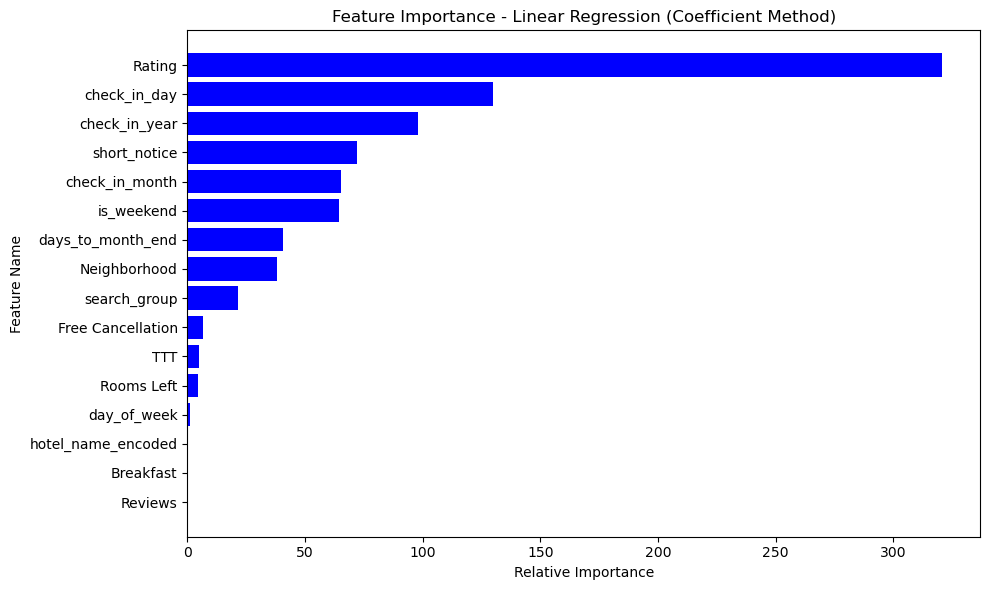


Linear Regression Feature Importance (Coefficient Method):
               Feature    Importance
0               Rating  3.207280e+02
1         check_in_day  1.296495e+02
2        check_in_year  9.797916e+01
3         short_notice  7.218403e+01
4       check_in_month  6.510773e+01
5           is_weekend  6.454178e+01
6    days_to_month_end  4.061877e+01
7         Neighborhood  3.822718e+01
8         search_group  2.166796e+01
9    Free Cancellation  6.491616e+00
10                 TTT  4.904914e+00
11          Rooms Left  4.661668e+00
12         day_of_week  1.124756e+00
13          is_weekend  3.317431e-01
14  hotel_name_encoded  5.023368e-02
15           Breakfast  2.015023e-02
16             Reviews  3.552714e-14
17         day_of_week  0.000000e+00


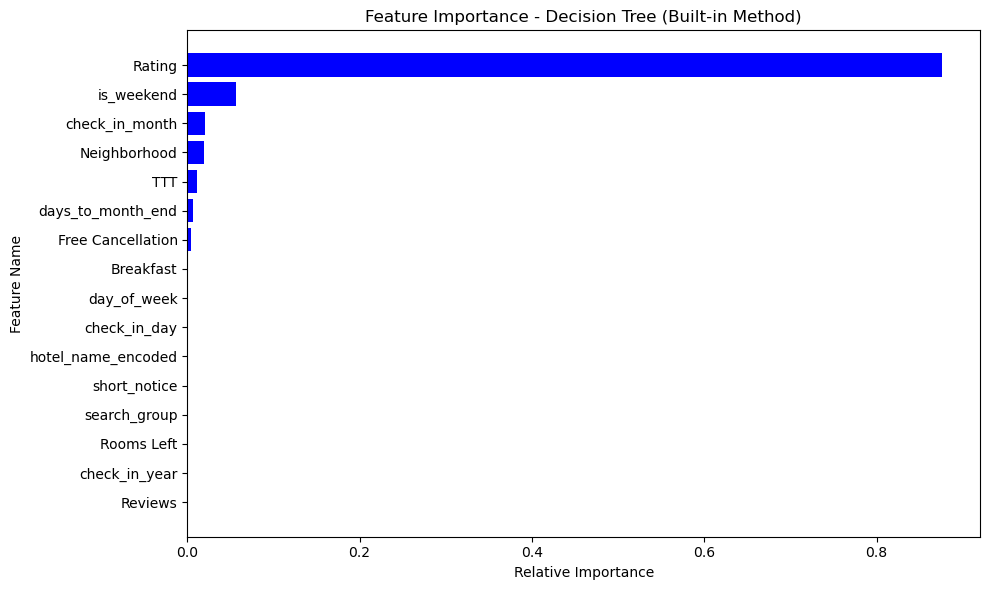


Decision Tree Feature Importance (Built-in Method):
               Feature  Importance
0               Rating    0.876317
1           is_weekend    0.056024
2       check_in_month    0.020394
3         Neighborhood    0.019199
4                  TTT    0.011573
5    days_to_month_end    0.006992
6    Free Cancellation    0.004348
7           is_weekend    0.003385
8            Breakfast    0.000796
9          day_of_week    0.000788
10        check_in_day    0.000128
11  hotel_name_encoded    0.000058
12        short_notice    0.000000
13         day_of_week    0.000000
14        search_group    0.000000
15          Rooms Left    0.000000
16       check_in_year    0.000000
17             Reviews    0.000000


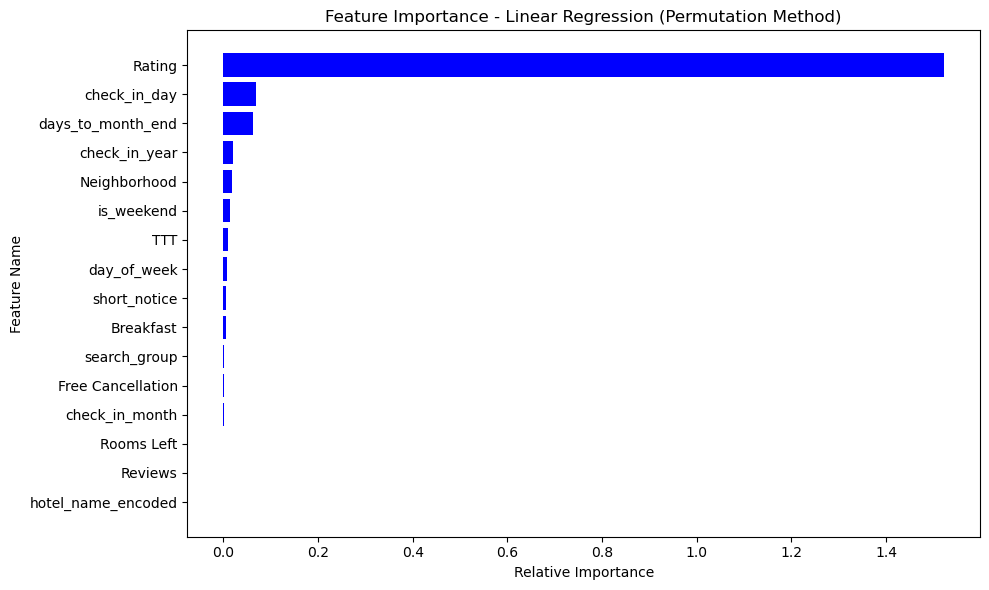


Linear Regression Feature Importance (Permutation Method):
               Feature  Importance
0               Rating    1.522244
1         check_in_day    0.068171
2    days_to_month_end    0.061711
3        check_in_year    0.020289
4         Neighborhood    0.018466
5           is_weekend    0.013373
6                  TTT    0.010223
7          day_of_week    0.008361
8         short_notice    0.004749
9            Breakfast    0.004356
10        search_group    0.001431
11   Free Cancellation    0.001094
12      check_in_month    0.000130
13          Rooms Left    0.000070
14          is_weekend    0.000005
15             Reviews    0.000000
16         day_of_week    0.000000
17  hotel_name_encoded   -0.000026


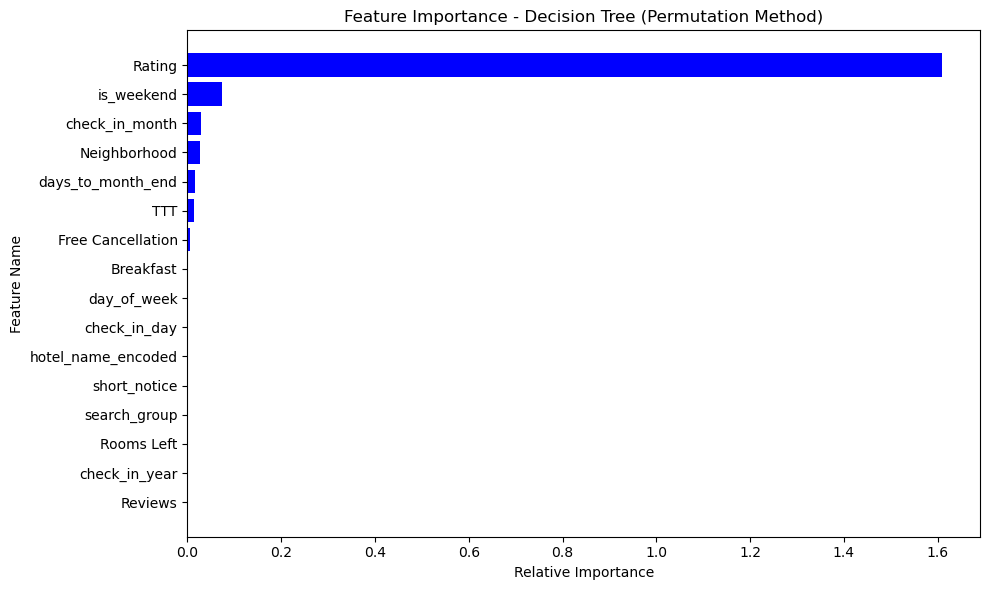


Decision Tree Feature Importance (Permutation Method):
               Feature  Importance
0               Rating    1.609671
1           is_weekend    0.074545
2       check_in_month    0.029890
3         Neighborhood    0.027779
4    days_to_month_end    0.016849
5                  TTT    0.013084
6    Free Cancellation    0.005673
7           is_weekend    0.004312
8            Breakfast    0.002125
9          day_of_week    0.000302
10        check_in_day    0.000287
11  hotel_name_encoded    0.000139
12        short_notice    0.000000
13         day_of_week    0.000000
14        search_group    0.000000
15          Rooms Left    0.000000
16       check_in_year    0.000000
17             Reviews    0.000000


In [29]:
# 1. Linear Regression Feature Importance - Coefficient Method

exclude_cols = ['Price', 'Snapshot Date', 'Check-in', 'Check-out','LOS','Hotel Name']
# Original columns after exclusion
original_features = [col for col in df.columns if col not in exclude_cols]
# Add engineered features
engineered_features = ['day_of_week', 'is_weekend', 'days_to_month_end', 'short_notice', 
                      'check_in_month', 'check_in_year', 'check_in_day']
# Combine both sets of features
feature_cols = original_features + engineered_features

# Now feature_cols should match the features in X_train
feature_names = np.array(feature_cols)

# Create and train the Linear Regression model
lr = LinearRegression()
lr.fit(X_train, y_train)

# Extract feature importance (using absolute coefficient values)
lr_importances = np.abs(lr.coef_)
feature_names = np.array(feature_cols)

# Sort importances in descending order
lr_indices = np.argsort(lr_importances)[::-1]

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.title("Feature Importance - Linear Regression (Coefficient Method)")
plt.barh(feature_names[lr_indices], lr_importances[lr_indices], color="blue", align="center")
plt.xlabel("Relative Importance")
plt.ylabel("Feature Name")
plt.gca().invert_yaxis()  # Highest importance at the top
plt.tight_layout()
plt.show()

# Display importance table
lr_importance_df = pd.DataFrame({
    "Feature": feature_names[lr_indices], 
    "Importance": lr_importances[lr_indices]
})
print("\nLinear Regression Feature Importance (Coefficient Method):")
print(lr_importance_df)

# 2. Decision Tree Feature Importance - Built-in Method (Algorithm-Specific)

# Create and train the Decision Tree model
dt = DecisionTreeRegressor(max_depth=6, min_samples_split=5, random_state=42)
dt.fit(X_train, y_train)

# Extract feature importance
dt_importances = dt.feature_importances_

# Sort importances in descending order
dt_indices = np.argsort(dt_importances)[::-1]

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.title("Feature Importance - Decision Tree (Built-in Method)")
plt.barh(feature_names[dt_indices], dt_importances[dt_indices], color="blue", align="center")
plt.xlabel("Relative Importance")
plt.ylabel("Feature Name")
plt.gca().invert_yaxis()  # Highest importance at the top
plt.tight_layout()
plt.show()

# Display importance table
dt_importance_df = pd.DataFrame({
    "Feature": feature_names[dt_indices], 
    "Importance": dt_importances[dt_indices]
})
print("\nDecision Tree Feature Importance (Built-in Method):")
print(dt_importance_df)

# ### 3. Linear Regression - Permutation Importance (Black-box Method)

# Create scaler for Linear Regression permutation importance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Linear Regression on scaled data
lr_scaled = LinearRegression()
lr_scaled.fit(X_train_scaled, y_train)

# Calculate permutation importance
# Use a subset of data for faster computation
sample_indices = np.random.choice(len(X_test_scaled), min(1000, len(X_test_scaled)), replace=False)
X_sample = X_test_scaled[sample_indices]
y_sample = y_test.iloc[sample_indices]

# Calculate permutation importance
try:
    lr_perm = permutation_importance(lr_scaled, X_sample, y_sample, 
                                    n_repeats=5, random_state=42, n_jobs=-1)
    
    # Sort importances
    lr_perm_indices = np.argsort(lr_perm.importances_mean)[::-1]
    
    # Plot permutation importance
    plt.figure(figsize=(10, 6))
    plt.title("Feature Importance - Linear Regression (Permutation Method)")
    plt.barh(feature_names[lr_perm_indices], lr_perm.importances_mean[lr_perm_indices], 
             color="blue", align="center")
    plt.xlabel("Relative Importance")
    plt.ylabel("Feature Name")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    # Display importance table
    lr_perm_df = pd.DataFrame({
        "Feature": feature_names[lr_perm_indices], 
        "Importance": lr_perm.importances_mean[lr_perm_indices]
    })
    print("\nLinear Regression Feature Importance (Permutation Method):")
    print(lr_perm_df)
except Exception as e:
    print(f"Error calculating permutation importance: {e}")

# 4. Decision Tree - Permutation Importance (Black-box Method)

# Calculate permutation importance for Decision Tree
try:
    dt_perm = permutation_importance(dt, X_test.values[sample_indices], 
                                    y_sample, n_repeats=5, random_state=42, n_jobs=-1)
    
    # Sort importances
    dt_perm_indices = np.argsort(dt_perm.importances_mean)[::-1]
    
    # Plot permutation importance
    plt.figure(figsize=(10, 6))
    plt.title("Feature Importance - Decision Tree (Permutation Method)")
    plt.barh(feature_names[dt_perm_indices], dt_perm.importances_mean[dt_perm_indices], 
             color="blue", align="center")
    plt.xlabel("Relative Importance")
    plt.ylabel("Feature Name")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    # Display importance table
    dt_perm_df = pd.DataFrame({
        "Feature": feature_names[dt_perm_indices], 
        "Importance": dt_perm.importances_mean[dt_perm_indices]
    })
    print("\nDecision Tree Feature Importance (Permutation Method):")
    print(dt_perm_df)
except Exception as e:
    print(f"Error calculating permutation importance: {e}")


# Neural Network

In [30]:
%pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


# Neural Network Regressor with MLP Architecture

This section implements a simple Multi-Layer Perceptron (MLP) neural network for predicting hotel prices. The architecture consists of:
- 64-node input layer with ReLU activation
- 32-node hidden layer with ReLU activation
- 16-node hidden layer with ReLU activation
- Single-node output layer (for price prediction)
- Dropout layers (0.2 and 0.1) to prevent overfitting

The model is trained with early stopping to find the optimal training duration.


--- Neural Network: Simple MLP Architecture ---
Epoch 1/100
780/780 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 626079.5000 - val_loss: 50775.9297
Epoch 2/100
780/780 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 64079.4648 - val_loss: 46914.7070
Epoch 3/100
780/780 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 61229.6680 - val_loss: 45102.7227
Epoch 4/100
780/780 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 58386.6797 - val_loss: 44454.5938
Epoch 5/100
780/780 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 56738.6641 - val_loss: 42658.2734
Epoch 6/100
780/780 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 56637.5234 - val_loss: 41557.7617
Epoch 7/100
780/780 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 56210.6719 - val_loss: 40502.6836
Epoch 8/100
780/780 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 53183.0586 - val_loss: 40433.7227
Epoch 9/100
780/780 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 53498.7070 - val_loss: 38957.1914
Epoch 10/100
780/780 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 53199.5430 - val_loss: 38485.7695

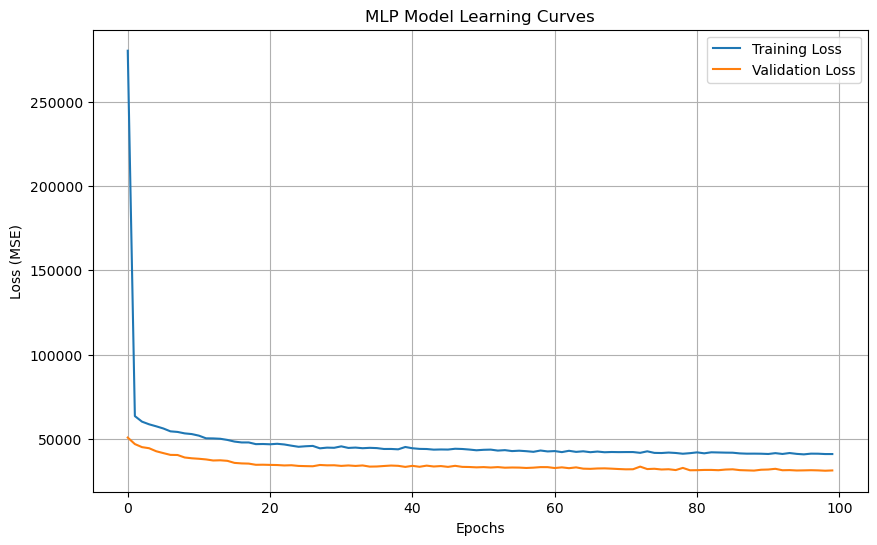

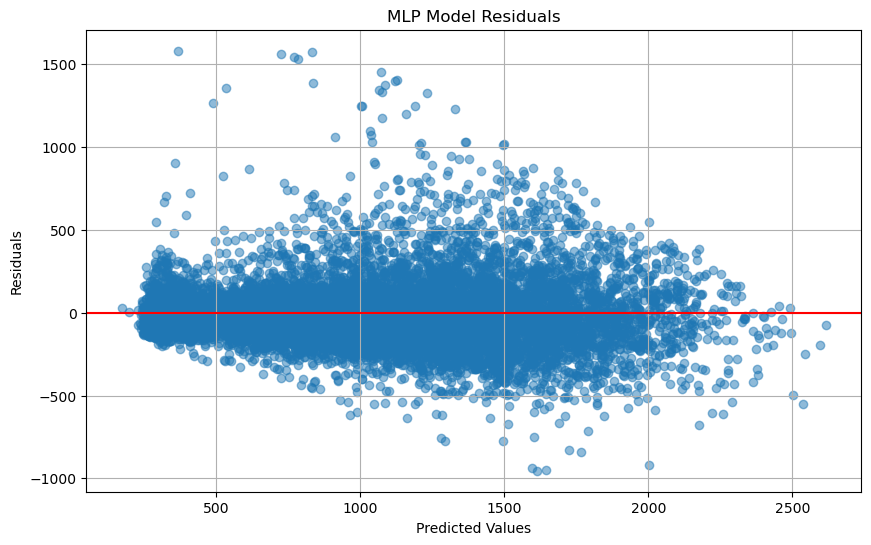

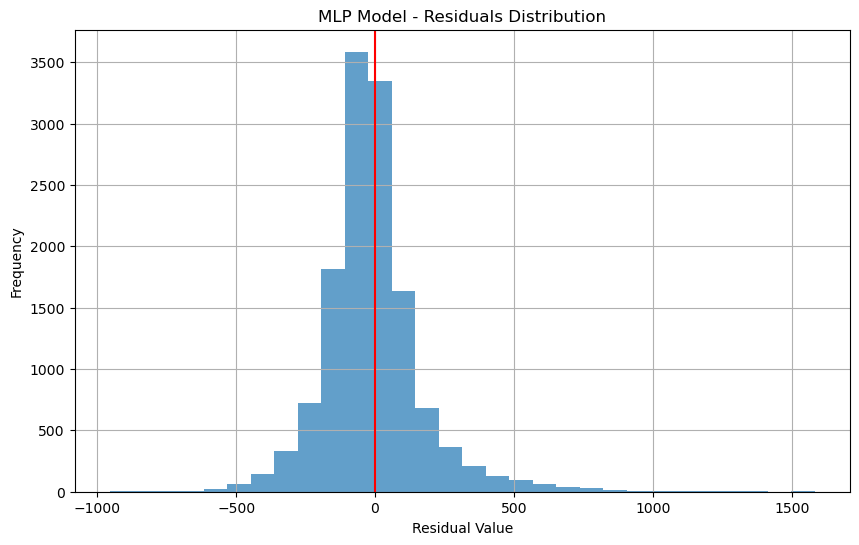

In [31]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Architecture 1: Simple MLP
def create_mlp_model(input_dim):
    model = Sequential([
        Dense(64, activation='relu', input_dim=input_dim),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dropout(0.1),
        Dense(16, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

# Train and evaluate MLP model
print("\n--- Neural Network: Simple MLP Architecture ---")
mlp_model = create_mlp_model(X_train_std.shape[1])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
mlp_history = mlp_model.fit(
    X_train_std, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

# Predict and evaluate
y_train_pred_mlp = mlp_model.predict(X_train_std).flatten()
y_test_pred_mlp = mlp_model.predict(X_test_std).flatten()

# Calculate metrics
train_mse_mlp = mean_squared_error(y_train, y_train_pred_mlp)
test_mse_mlp = mean_squared_error(y_test, y_test_pred_mlp)
train_rmse_mlp = np.sqrt(train_mse_mlp)
test_rmse_mlp = np.sqrt(test_mse_mlp)
train_mae_mlp = mean_absolute_error(y_train, y_train_pred_mlp)
test_mae_mlp = mean_absolute_error(y_test, y_test_pred_mlp)
train_r2_mlp = r2_score(y_train, y_train_pred_mlp)
test_r2_mlp = r2_score(y_test, y_test_pred_mlp)

print("\nMLP Neural Network Performance:")
print(f"Train MSE: {train_mse_mlp:.2f}, Test MSE: {test_mse_mlp:.2f}")
print(f"Train RMSE: {train_rmse_mlp:.2f}, Test RMSE: {test_rmse_mlp:.2f}")
print(f"Train MAE: {train_mae_mlp:.2f}, Test MAE: {test_mae_mlp:.2f}")
print(f"Train R²: {train_r2_mlp:.4f}, Test R²: {test_r2_mlp:.4f}")

# Plot learning curve
plt.figure(figsize=(10, 6))
plt.plot(mlp_history.history['loss'], label='Training Loss')
plt.plot(mlp_history.history['val_loss'], label='Validation Loss')
plt.title('MLP Model Learning Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

# Plot MLP residuals
plt.figure(figsize=(10, 6))
residuals_mlp = y_test - y_test_pred_mlp
plt.scatter(y_test_pred_mlp, residuals_mlp, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='-')
plt.title('MLP Model Residuals')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()

# Plot residual distribution
plt.figure(figsize=(10, 6))
plt.hist(residuals_mlp, bins=30, alpha=0.7)
plt.axvline(x=0, color='r', linestyle='-')
plt.title('MLP Model - Residuals Distribution')
plt.xlabel('Residual Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Advanced Neural Network with Hotel Embedding Architecture

This section implements a more sophisticated neural network that uses embedding to handle categorical data (hotel names). The architecture includes:
- Separate input paths for numeric features and hotel identifiers
- Embedding layer to convert hotel IDs into learnable vectors
- Feature fusion through concatenation
- Multi-layer network with mixed activation functions (tanh, sigmoid, and ReLU)
- Dropout layers for regularization


--- Neural Network: Hotel Embedding Architecture ---


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 17)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 1, 10)     │         20 │ input_layer_6[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 32)        │        576 │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 10)        │          0 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 42)        │          0 │ dense_17[0][0],   │
│ (Concatenate)       │                   │            │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 64)        │      2,752 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 64)        │          0 │ dense_18[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 32)        │      2,080 │ dropout_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 32)        │          0 │ dense_19[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 16)        │        528 │ dropout_9[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_21 (Dense)    │ (None, 1)         │         17 │ dense_20[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,973 (23.33 KB)

 Trainable params: 5,973 (23.33 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
780/780 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 1141231.0000 - val_loss: 721583.4375
Epoch 2/100
780/780 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 610155.1875 - val_loss: 309778.5312
Epoch 3/100
780/780 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 303680.0312 - val_loss: 271847.4062
Epoch 4/100
780/780 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 269940.5938 - val_loss: 87234.4531
Epoch 5/100
780/780 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 85815.7734 - val_loss: 47962.5469
Epoch 6/100
780/780 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 58503.0039 - val_loss: 40393.1406
Epoch 7/100
780/780 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 52113.7305 - val_loss: 37380.3477
Epoch 8/100
780/780 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 49229.3477 - val_loss: 35683.4688
Epoch 9/100
780/780 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 47008.7773 - val_loss: 34342.4336
Epoch 10/100
780/780 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 46320.8438 - val_loss: 34326.5820
Epoch 11/100
780/780 ━━━━━━━━━━━━━━━━━━━━

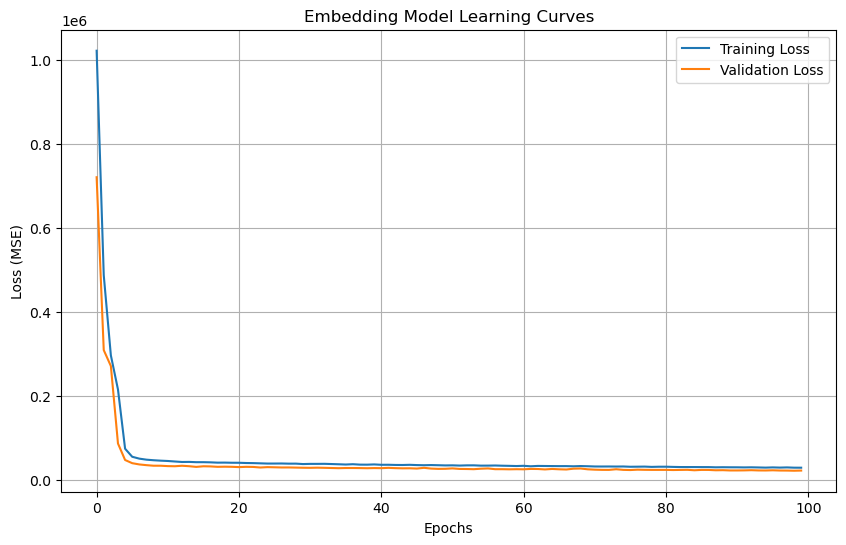

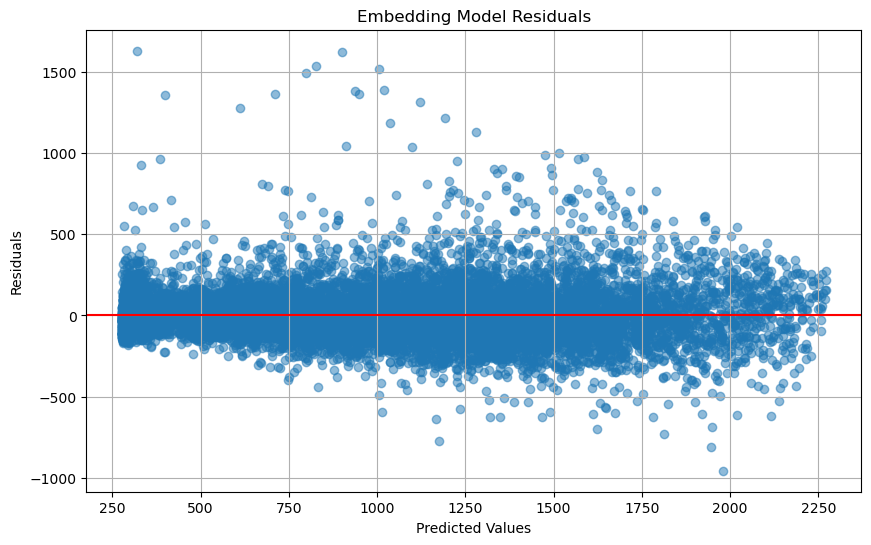

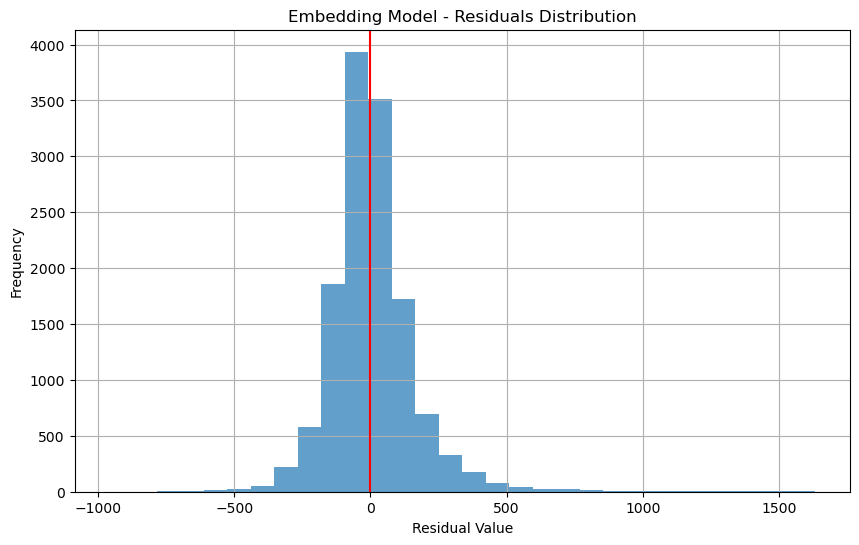

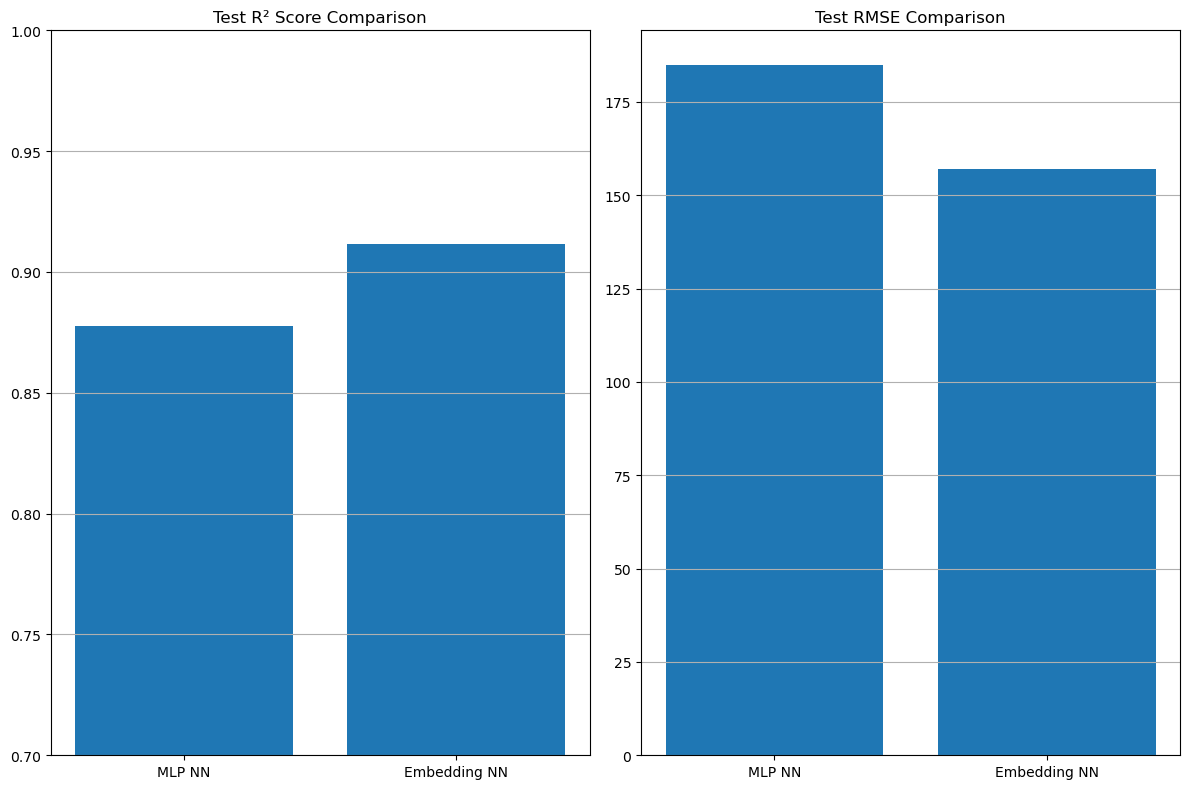

In [32]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Embedding, Flatten, Concatenate, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

# Prepare data for embedding model
# Extract hotel name column and convert to numeric IDs
hotel_names = X_train['Hotel Name'].unique()
hotel_to_id = {name: idx+1 for idx, name in enumerate(hotel_names)}

# Create hotel ID columns
X_train_hotel_id = np.array([hotel_to_id.get(hotel, 0) for hotel in X_train['Hotel Name']])
X_test_hotel_id = np.array([hotel_to_id.get(hotel, 0) for hotel in X_test['Hotel Name']])

# Create numeric features without hotel name
X_train_numeric = X_train.drop('Hotel Name', axis=1).values
X_test_numeric = X_test.drop('Hotel Name', axis=1).values

# Normalize numeric features
scaler_emb = StandardScaler()
X_train_numeric_scaled = scaler_emb.fit_transform(X_train_numeric)
X_test_numeric_scaled = scaler_emb.transform(X_test_numeric)

# Architecture 2: Using embeddings for hotel
print("\n--- Neural Network: Hotel Embedding Architecture ---")

# Create embedding model
def create_embedding_model(numeric_input_dim, num_hotels):
    # Input for numerical features
    numerical_input = Input(shape=(numeric_input_dim,))
    numeric_dense = Dense(32, activation='relu')(numerical_input)
    
    # Input for hotel ID
    hotel_input = Input(shape=(1,))
    hotel_embedding = Embedding(num_hotels+1, 10, input_length=1)(hotel_input)
    hotel_flatten = Flatten()(hotel_embedding)
    
    # Combine numerical data and hotel embedding
    combined = Concatenate()([numeric_dense, hotel_flatten])
    
    # Dense layers
    x = Dense(64, activation='tanh')(combined)
    x = Dropout(0.2)(x)
    x = Dense(32, activation='sigmoid')(x)
    x = Dropout(0.2)(x)
    x = Dense(16, activation='relu')(x)
    output = Dense(1)(x)
    
    # Create model
    model = Model(inputs=[numerical_input, hotel_input], outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

# Train embedding model
embedding_model = create_embedding_model(X_train_numeric_scaled.shape[1], len(hotel_names))

# Print model summary
embedding_model.summary()

early_stopping_emb = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

emb_history = embedding_model.fit(
    [X_train_numeric_scaled, X_train_hotel_id.reshape(-1, 1)], 
    y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping_emb],
    verbose=1
)

# Predict and evaluate
y_train_pred_emb = embedding_model.predict([X_train_numeric_scaled, X_train_hotel_id.reshape(-1, 1)]).flatten()
y_test_pred_emb = embedding_model.predict([X_test_numeric_scaled, X_test_hotel_id.reshape(-1, 1)]).flatten()

# Calculate metrics
train_mse_emb = mean_squared_error(y_train, y_train_pred_emb)
test_mse_emb = mean_squared_error(y_test, y_test_pred_emb)
train_rmse_emb = np.sqrt(train_mse_emb)
test_rmse_emb = np.sqrt(test_mse_emb)
train_mae_emb = mean_absolute_error(y_train, y_train_pred_emb)
test_mae_emb = mean_absolute_error(y_test, y_test_pred_emb)
train_r2_emb = r2_score(y_train, y_train_pred_emb)
test_r2_emb = r2_score(y_test, y_test_pred_emb)

print("\nEmbedding Neural Network Performance:")
print(f"Train MSE: {train_mse_emb:.2f}, Test MSE: {test_mse_emb:.2f}")
print(f"Train RMSE: {train_rmse_emb:.2f}, Test RMSE: {test_rmse_emb:.2f}")
print(f"Train MAE: {train_mae_emb:.2f}, Test MAE: {test_mae_emb:.2f}")
print(f"Train R²: {train_r2_emb:.4f}, Test R²: {test_r2_emb:.4f}")

# Plot learning curve for embedding model
plt.figure(figsize=(10, 6))
plt.plot(emb_history.history['loss'], label='Training Loss')
plt.plot(emb_history.history['val_loss'], label='Validation Loss')
plt.title('Embedding Model Learning Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

# Plot embedding model residuals
plt.figure(figsize=(10, 6))
residuals_emb = y_test - y_test_pred_emb
plt.scatter(y_test_pred_emb, residuals_emb, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='-')
plt.title('Embedding Model Residuals')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()

# Plot residual distribution
plt.figure(figsize=(10, 6))
plt.hist(residuals_emb, bins=30, alpha=0.7)
plt.axvline(x=0, color='r', linestyle='-')
plt.title('Embedding Model - Residuals Distribution')
plt.xlabel('Residual Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Compare both NNs
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
models = ['MLP NN', 'Embedding NN']
r2_scores = [test_r2_mlp, test_r2_emb]
plt.bar(models, r2_scores)
plt.title('Test R² Score Comparison')
plt.ylim(0.7, 1.0)
plt.grid(axis='y')

plt.subplot(1, 2, 2)
rmse_scores = [test_rmse_mlp, test_rmse_emb]
plt.bar(models, rmse_scores)
plt.title('Test RMSE Comparison')
plt.grid(axis='y')

plt.tight_layout()
plt.show()

# Testing best model with different split

TTT-Based Split:
Train set (TTT <= 25): 37284 samples (83.8%)
Test set (TTT > 25): 7234 samples (16.2%)

TTT-based training set size: (37284, 18)
TTT-based test set size: (7234, 18)


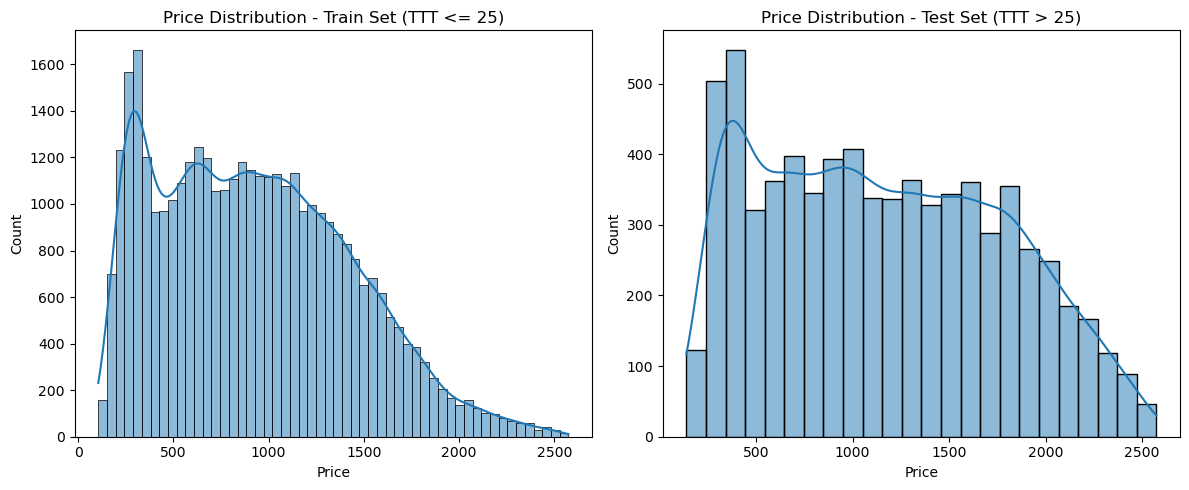


--- Gradient Boosting Regressor with TTT-based split ---

Gradient Boosting Regressor Performance with TTT-based split:
Train set (TTT <= 25) MSE: 24112.08, Test set (TTT > 25) MSE: 63070.05
Train set (TTT <= 25) RMSE: 155.28, Test set (TTT > 25) RMSE: 251.14
Train set (TTT <= 25) MAE: 102.27, Test set (TTT > 25) MAE: 168.46
Train set (TTT <= 25) R²: 0.9043, Test set (TTT > 25) R²: 0.8312


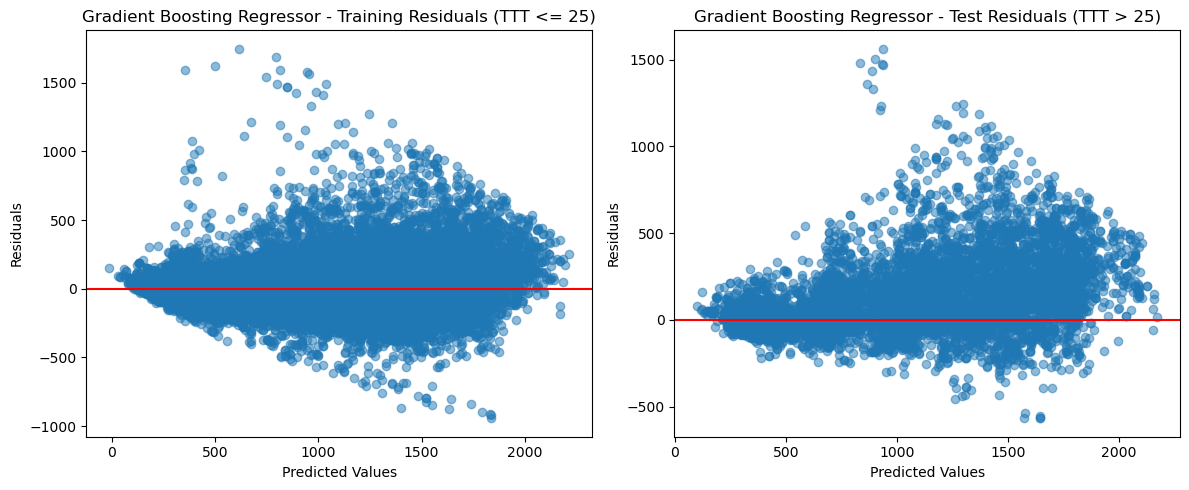

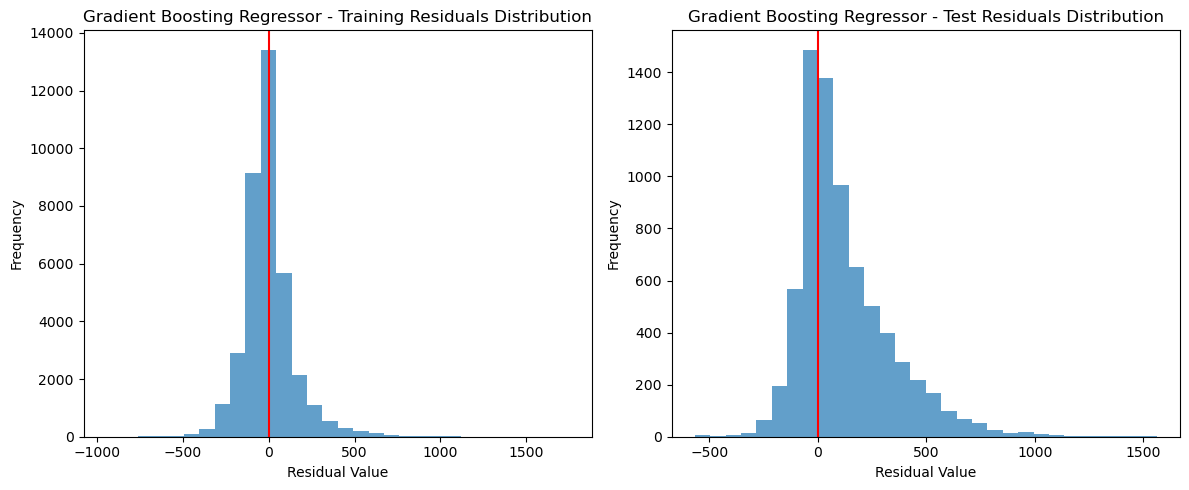

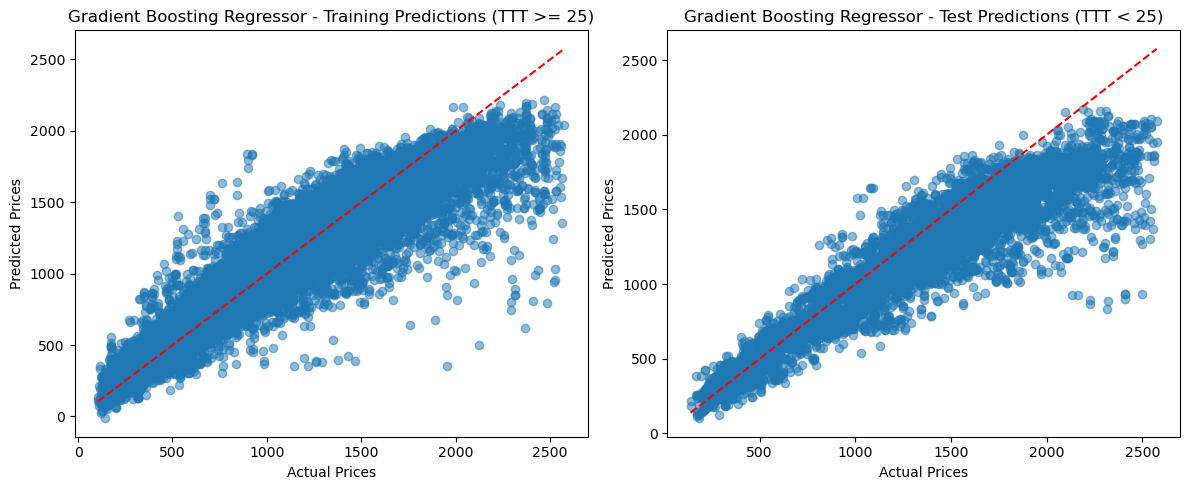


--- Summary: Gradient Boosting with TTT-based Split ---
Test R²: 0.8312
Test RMSE: 251.14
Test MAE: 168.46


In [35]:
# Time-Based Train-Test Split for Gradient Boosting
# Train: TTT <= 25 days, Test: TTT > 25 days

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor

# Function to evaluate model with TTT-based split
def evaluate_model_ttt_split(model, X_train, X_test, y_train, y_test, model_name="Model"):
    # Train and predict
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate metrics
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    train_rmse = np.sqrt(train_mse)
    test_rmse = np.sqrt(test_mse)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    # Print results
    print(f"\n{model_name} Performance with TTT-based split:")
    print(f"Train set (TTT <= 25) MSE: {train_mse:.2f}, Test set (TTT > 25) MSE: {test_mse:.2f}")
    print(f"Train set (TTT <= 25) RMSE: {train_rmse:.2f}, Test set (TTT > 25) RMSE: {test_rmse:.2f}")
    print(f"Train set (TTT <= 25) MAE: {train_mae:.2f}, Test set (TTT > 25) MAE: {test_mae:.2f}")
    print(f"Train set (TTT <= 25) R²: {train_r2:.4f}, Test set (TTT > 25) R²: {test_r2:.4f}")
    
    # Plot residuals
    plt.figure(figsize=(12, 5))
    
    # Training residuals
    plt.subplot(1, 2, 1)
    residuals_train = y_train - y_train_pred
    plt.scatter(y_train_pred, residuals_train, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='-')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title(f'{model_name} - Training Residuals (TTT <= 25)')
    
    # Test residuals
    plt.subplot(1, 2, 2)
    residuals_test = y_test - y_test_pred
    plt.scatter(y_test_pred, residuals_test, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='-')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title(f'{model_name} - Test Residuals (TTT > 25)')
    
    plt.tight_layout()
    plt.show()
    
    # Plot a residual histogram
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.hist(residuals_train, bins=30, alpha=0.7)
    plt.axvline(x=0, color='r', linestyle='-')
    plt.xlabel('Residual Value')
    plt.ylabel('Frequency')
    plt.title(f'{model_name} - Training Residuals Distribution')
    
    plt.subplot(1, 2, 2)
    plt.hist(residuals_test, bins=30, alpha=0.7)
    plt.axvline(x=0, color='r', linestyle='-')
    plt.xlabel('Residual Value')
    plt.ylabel('Frequency')
    plt.title(f'{model_name} - Test Residuals Distribution')
    
    plt.tight_layout()
    plt.show()
    
    # Plot actual vs predicted values
    plt.figure(figsize=(12, 5))
    
    # Training data
    plt.subplot(1, 2, 1)
    plt.scatter(y_train, y_train_pred, alpha=0.5)
    plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--')
    plt.xlabel('Actual Prices')
    plt.ylabel('Predicted Prices')
    plt.title(f'{model_name} - Training Predictions (TTT >= 25)')
    
    # Test data
    plt.subplot(1, 2, 2)
    plt.scatter(y_test, y_test_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual Prices')
    plt.ylabel('Predicted Prices')
    plt.title(f'{model_name} - Test Predictions (TTT < 25)')
    
    plt.tight_layout()
    plt.show()
    
    # Return metrics
    return {
        'model': model,
        'train_mse': train_mse,
        'test_mse': test_mse,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_mae': train_mae,
        'test_mae': test_mae,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'y_test_pred': y_test_pred
    }

# Create TTT-based split
# Train: TTT >= 25, Test: TTT < 25
mask_train = df['TTT'] <= 25
mask_test = df['TTT'] > 25

# Check the size of each split
train_size = sum(mask_train)
test_size = sum(mask_test)
print(f"TTT-Based Split:")
print(f"Train set (TTT <= 25): {train_size} samples ({100*train_size/len(df):.1f}%)")
print(f"Test set (TTT > 25): {test_size} samples ({100*test_size/len(df):.1f}%)")

# Create feature and target for the new split
X = df.drop(['Price', 'Snapshot Date', 'Check-in', 'Check-out'], axis=1)
y = df['Price']

# Convert any remaining object columns to numeric if needed
for col in X.select_dtypes(include=['object']).columns:
    X[col] = pd.to_numeric(X[col], errors='coerce')
    
# Fill any NaN values created by conversion
X = X.fillna(-1)

# Create the split
X_train_ttt = X[mask_train]
X_test_ttt = X[mask_test]
y_train_ttt = y[mask_train]
y_test_ttt = y[mask_test]

print(f"\nTTT-based training set size: {X_train_ttt.shape}")
print(f"TTT-based test set size: {X_test_ttt.shape}")

# Analyze distribution of prices in both sets
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(y_train_ttt, kde=True)
plt.title('Price Distribution - Train Set (TTT <= 25)')
plt.xlabel('Price')

plt.subplot(1, 2, 2)
sns.histplot(y_test_ttt, kde=True)
plt.title('Price Distribution - Test Set (TTT > 25)')
plt.xlabel('Price')

plt.tight_layout()
plt.show()

# Train Gradient Boosting with TTT-based split
print("\n--- Gradient Boosting Regressor with TTT-based split ---")
gb_model_ttt = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_results_ttt = evaluate_model_ttt_split(gb_model_ttt, X_train_ttt, X_test_ttt, y_train_ttt, y_test_ttt, 
                                         "Gradient Boosting Regressor")

# Print summary of results
print("\n--- Summary: Gradient Boosting with TTT-based Split ---")
print(f"Test R²: {gb_results_ttt['test_r2']:.4f}")
print(f"Test RMSE: {gb_results_ttt['test_rmse']:.2f}")
print(f"Test MAE: {gb_results_ttt['test_mae']:.2f}")

Based on the results of our time-based split experiment with Gradient Boosting, we can see that a great results kept also in the new data split.

These findings suggest that hotel pricing dynamics change significantly as the check-in date approaches, creating challenges for models trained on earlier booking windows. For practical applications, this indicates that separate models or additional time-based features may be necessary to accurately predict how prices evolve throughout the booking timeline.